# 프로젝트 주식 예측


- https://finance.yahoo.com/
    

## liabry import


In [111]:

import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.
# font set
font_path = '/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=3)


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math



## data import

In [87]:


file_path = './data/samsung.KS.csv'
#file_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/E06-Stationary_Time_Series/data/samsung.KS.csv' 
df = pd.read_csv(file_path, index_col="Date", parse_dates=True)
#parse_dates 날짜 시간 parsing 하기 fillna 결측값 채우기

ts = df['Close']
print(type(ts))
df.head()

<class 'pandas.core.series.Series'>


Open    High     Low   Close  Adj Close      Volume
Date                                                             
2000-01-04  6000.0  6110.0  5660.0  6110.0   0.090599  74195000.0
2000-01-05  5800.0  6060.0  5520.0  5580.0   0.082740  74680000.0
2000-01-06  5750.0  5780.0  5580.0  5620.0   0.083333  54390000.0
2000-01-07  5560.0  5670.0  5360.0  5540.0   0.082147  40305000.0
2000-01-10  5600.0  5770.0  5580.0  5770.0   0.085558  46880000.0

## 각종 전처리 수행

In [88]:
# 결측치 처리
# [[YOUR CODE]]

# fillna(0) 0으로 대체
# interpolate 결측값 제거 행열로..
#.dropna(inplace=True) 결츨ㄱ값 제거 행열로..
print(ts[ts.isna()]  )
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Date
2000-12-25   NaN
2001-01-23   NaN
2001-01-24   NaN
2001-01-25   NaN
2001-03-14   NaN
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64


Series([], Name: Close, dtype: float64)

In [89]:
# 로그 변환
ts_log = np.log(ts)
ts_log.head()


Date
2000-01-04    8.717682
2000-01-05    8.626944
2000-01-06    8.634087
2000-01-07    8.619750
2000-01-10    8.660427
Name: Close, dtype: float64

In [90]:
# 파일로 저장해보기
#ts_log.to_csv('sample_file.txt', index=False, header=None, sep="\t")

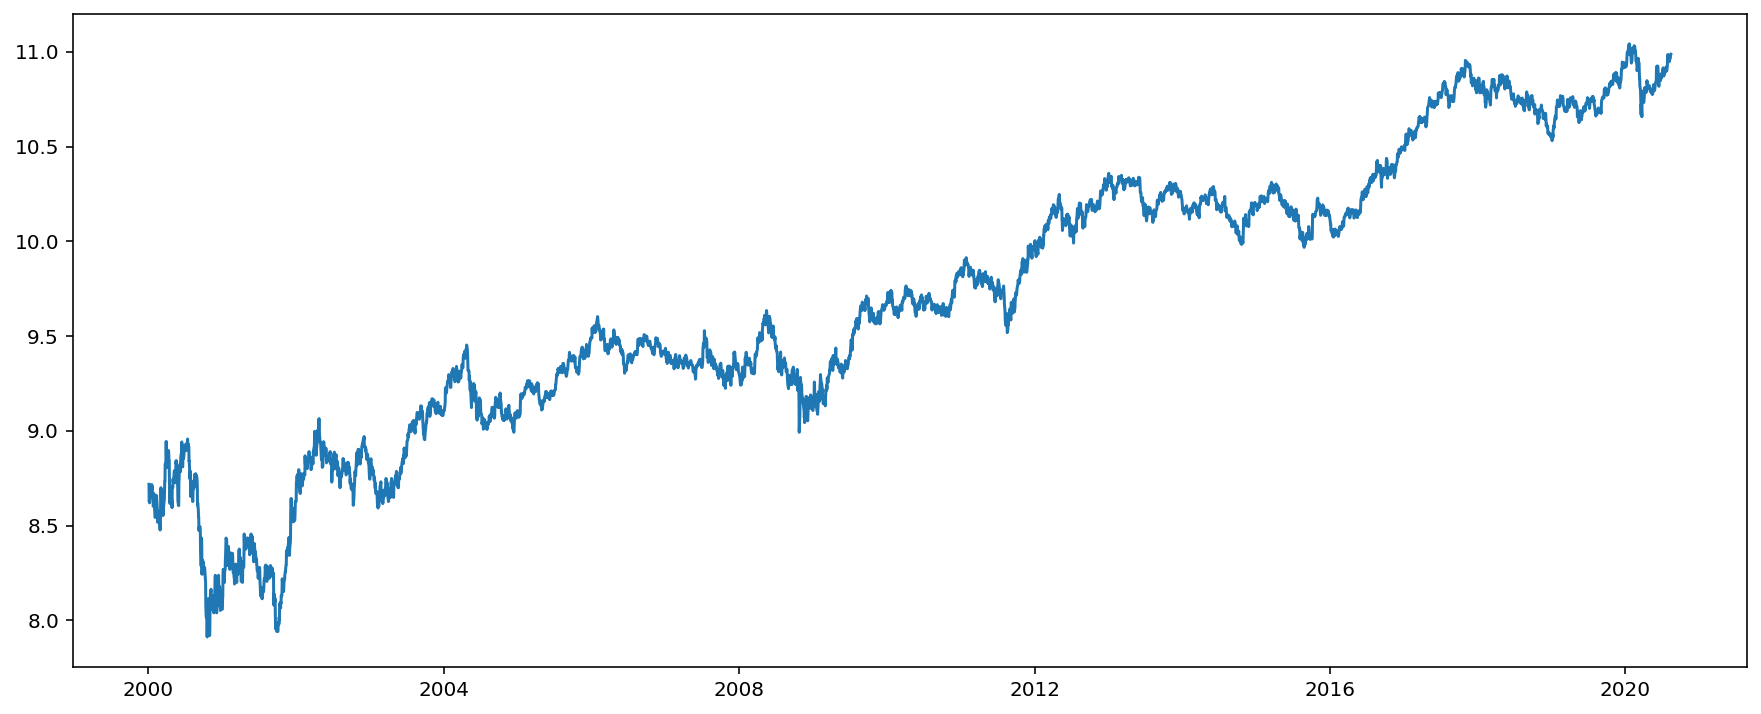

In [112]:
plt.plot(ts_log)

## 시계열 안정성 분석

### 정성적 그래프 분석

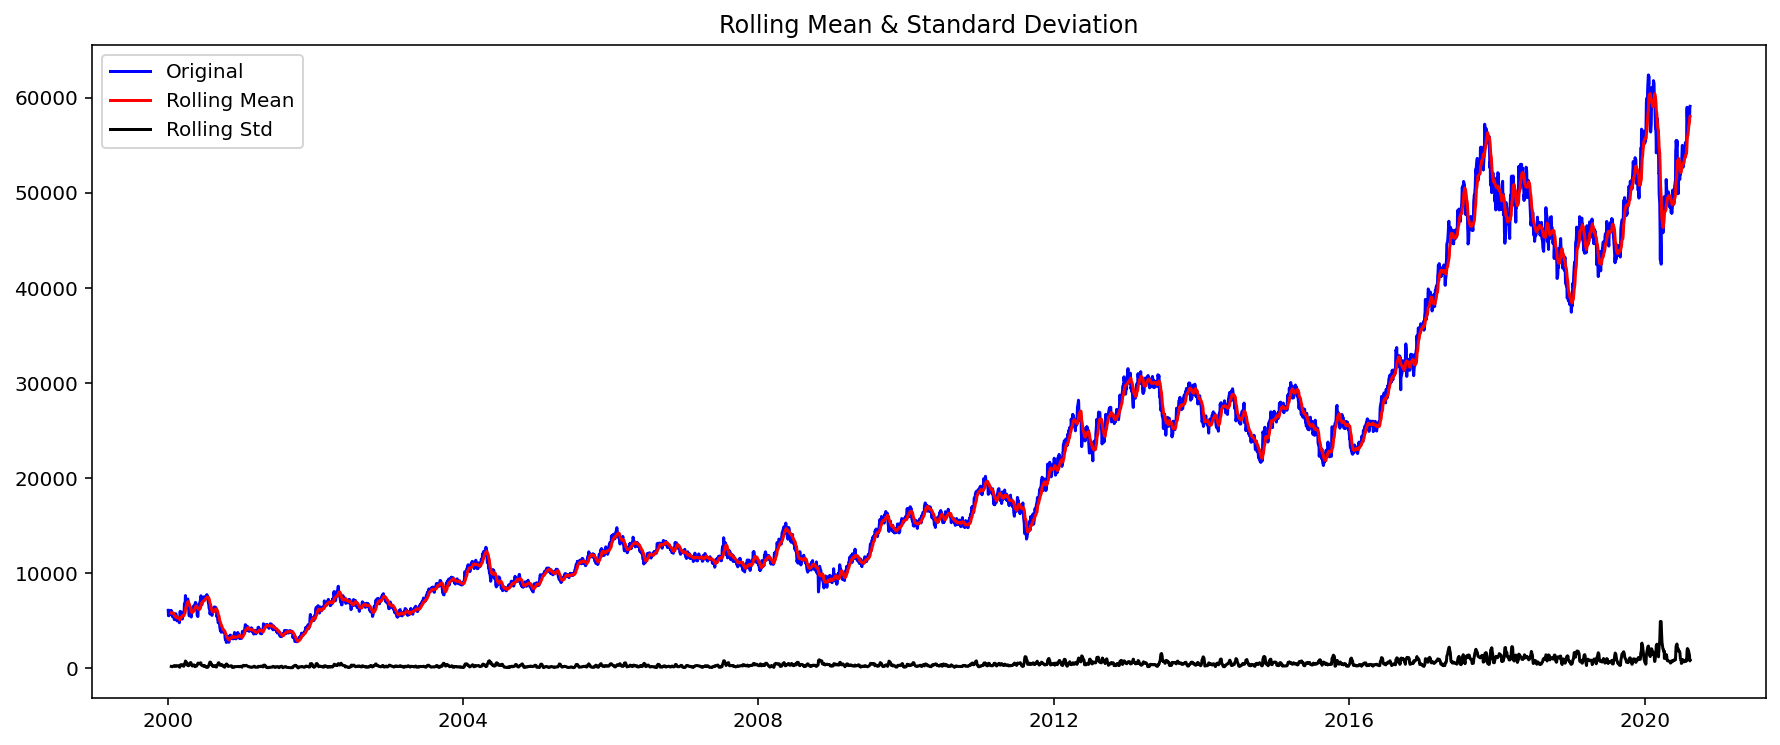

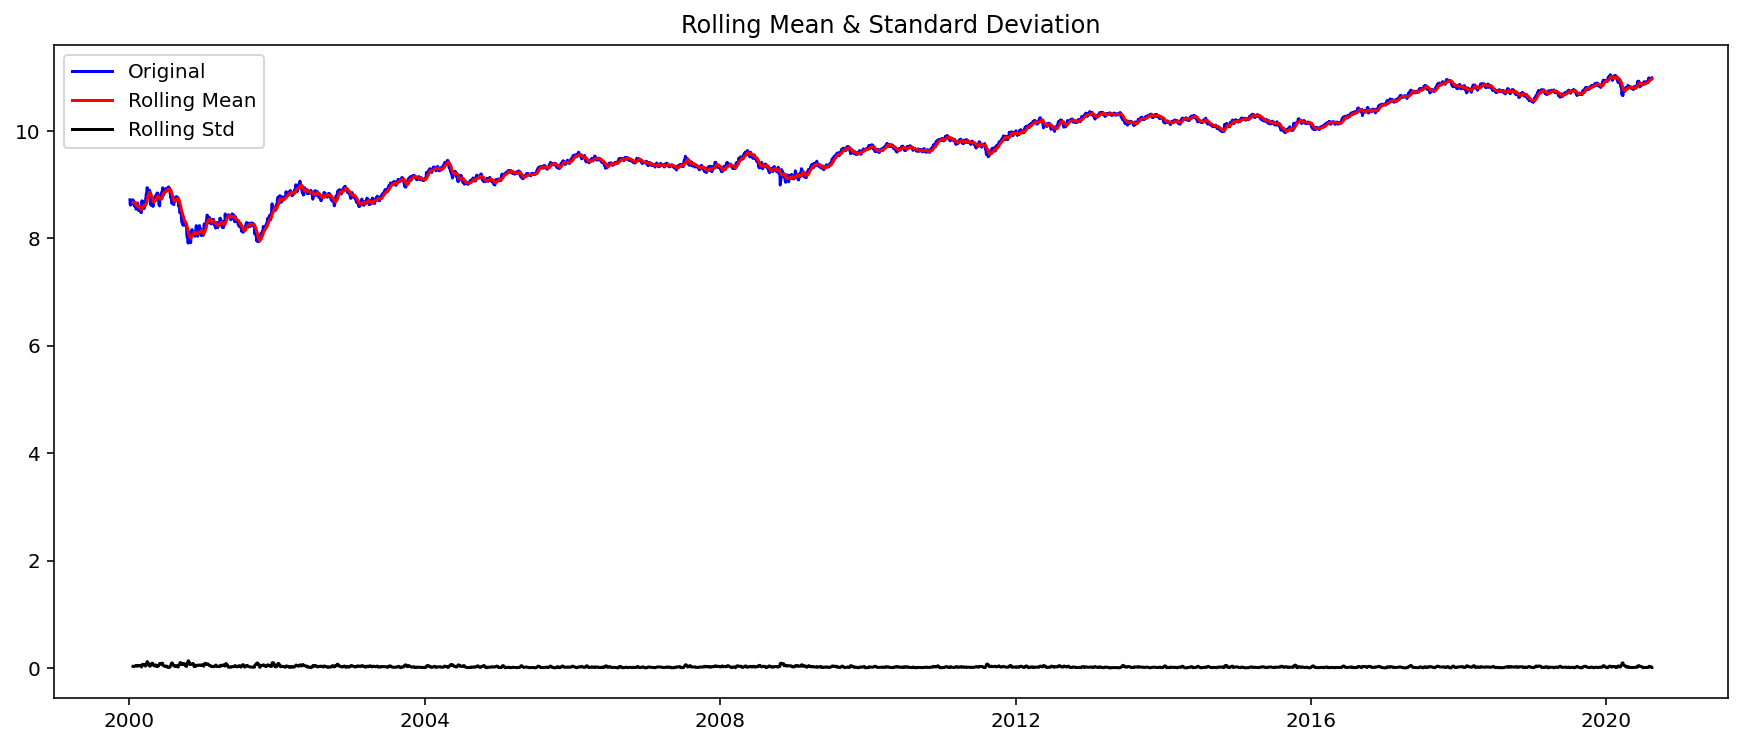

In [100]:

## 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):

    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열
    # window 개씩 이동 평균을 냄.
#     print(timeseries)
#     print(rolmean)
#     print(rolstd)
    
     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    #plt.ylim(7,10)
    plt.show(block=False)
    
#함수정의
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#로그 전.
plot_rolling_statistics(ts, window=12)
# 로그 후.
plot_rolling_statistics(ts_log, window=12)


### 정량적 Augmented Dicky-Fuller Test

In [168]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.679939
p-value                           0.851878
#Lags Used                        4.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


#### - moving avg

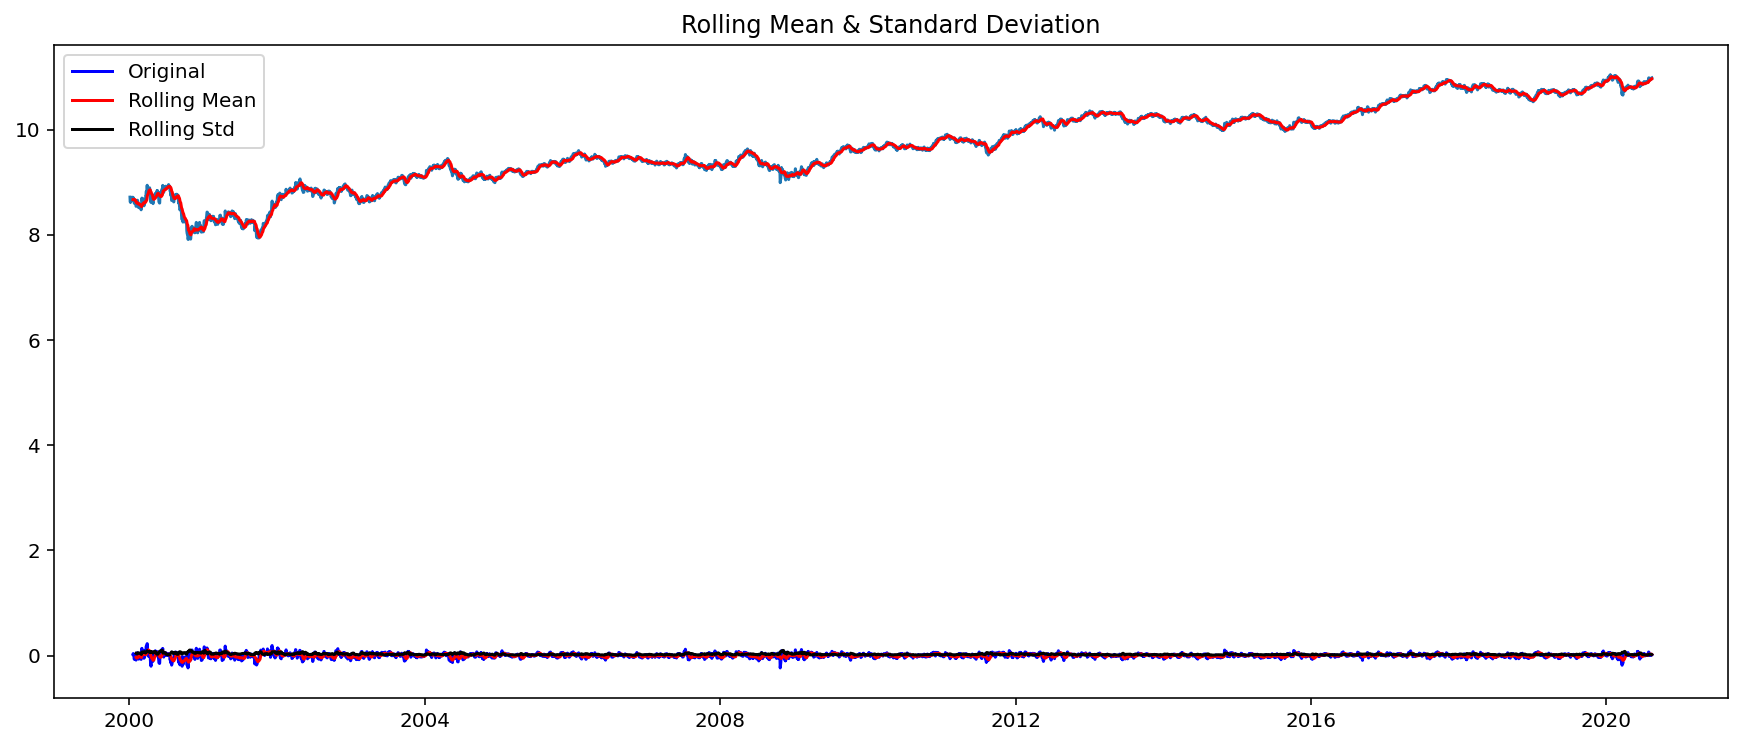

Results of Dickey-Fuller Test:
Test Statistic                -1.649004e+01
p-value                        2.196660e-29
#Lags Used                     1.100000e+01
Number of Observations Used    5.164000e+03
Critical Value (1%)           -3.431617e+00
Critical Value (5%)           -2.862100e+00
Critical Value (10%)          -2.567068e+00
dtype: float64


In [102]:

moving_avg = ts_log.rolling(window=12).mean()  # moving average를 구해서 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(15)
#nan 숙청
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

# - movingavg
plot_rolling_statistics(ts_log_moving_avg)
augmented_dickey_fuller_test(ts_log_moving_avg)

#### 차분 상쇄

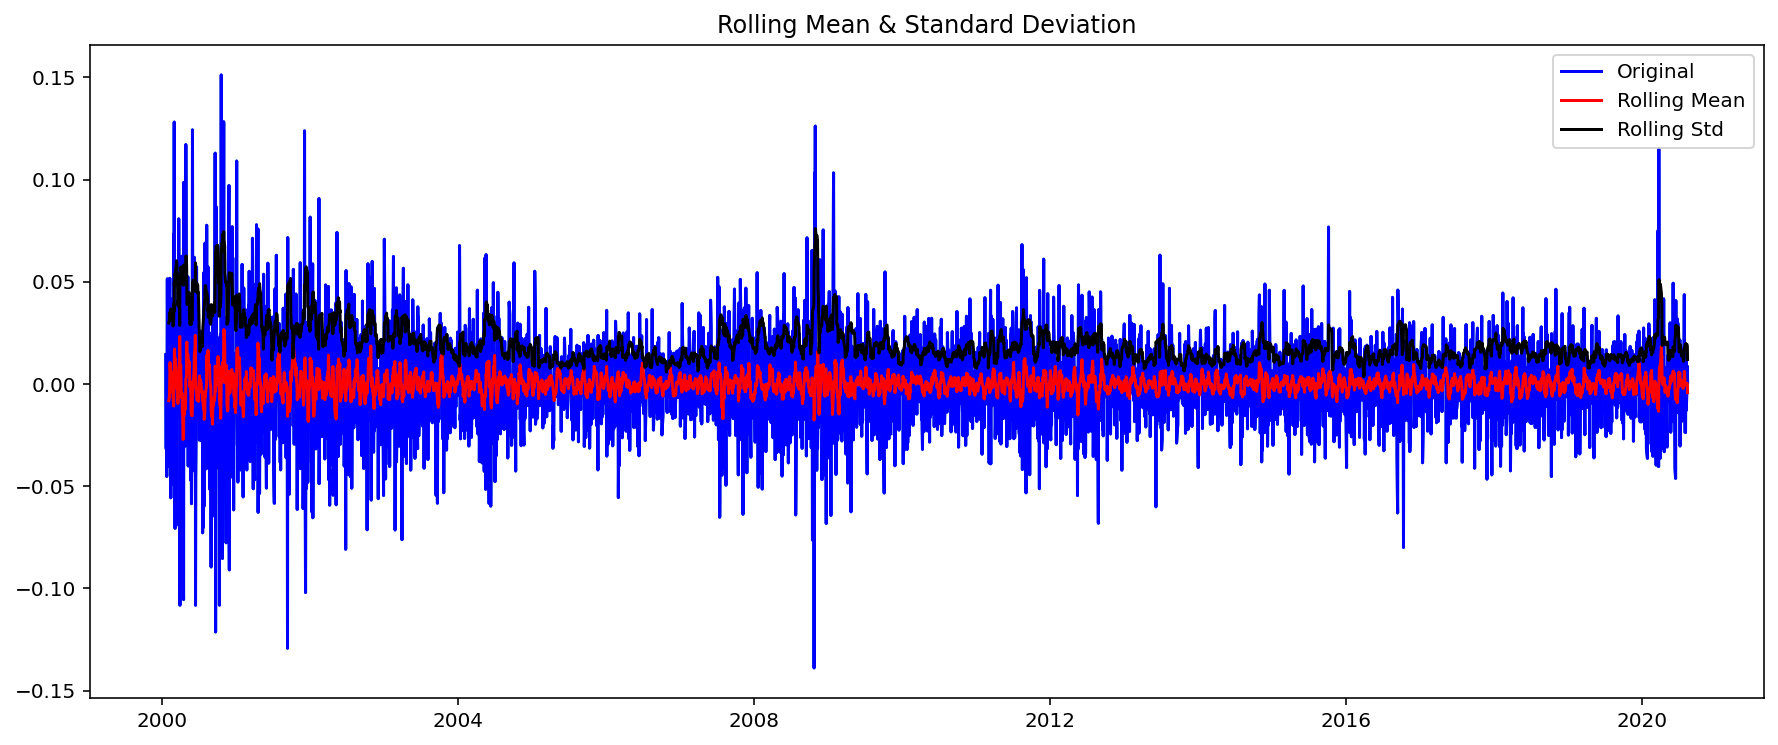

Results of Dickey-Fuller Test:
Test Statistic                  -19.503569
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5141.000000
Critical Value (1%)              -3.431623
Critical Value (5%)              -2.862102
Critical Value (10%)             -2.567069
dtype: float64


In [103]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()
# 현제 값과 직전 값을 차를 그래프로~
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

plot_rolling_statistics(ts_log_moving_avg_diff)
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

### 시계열 분석

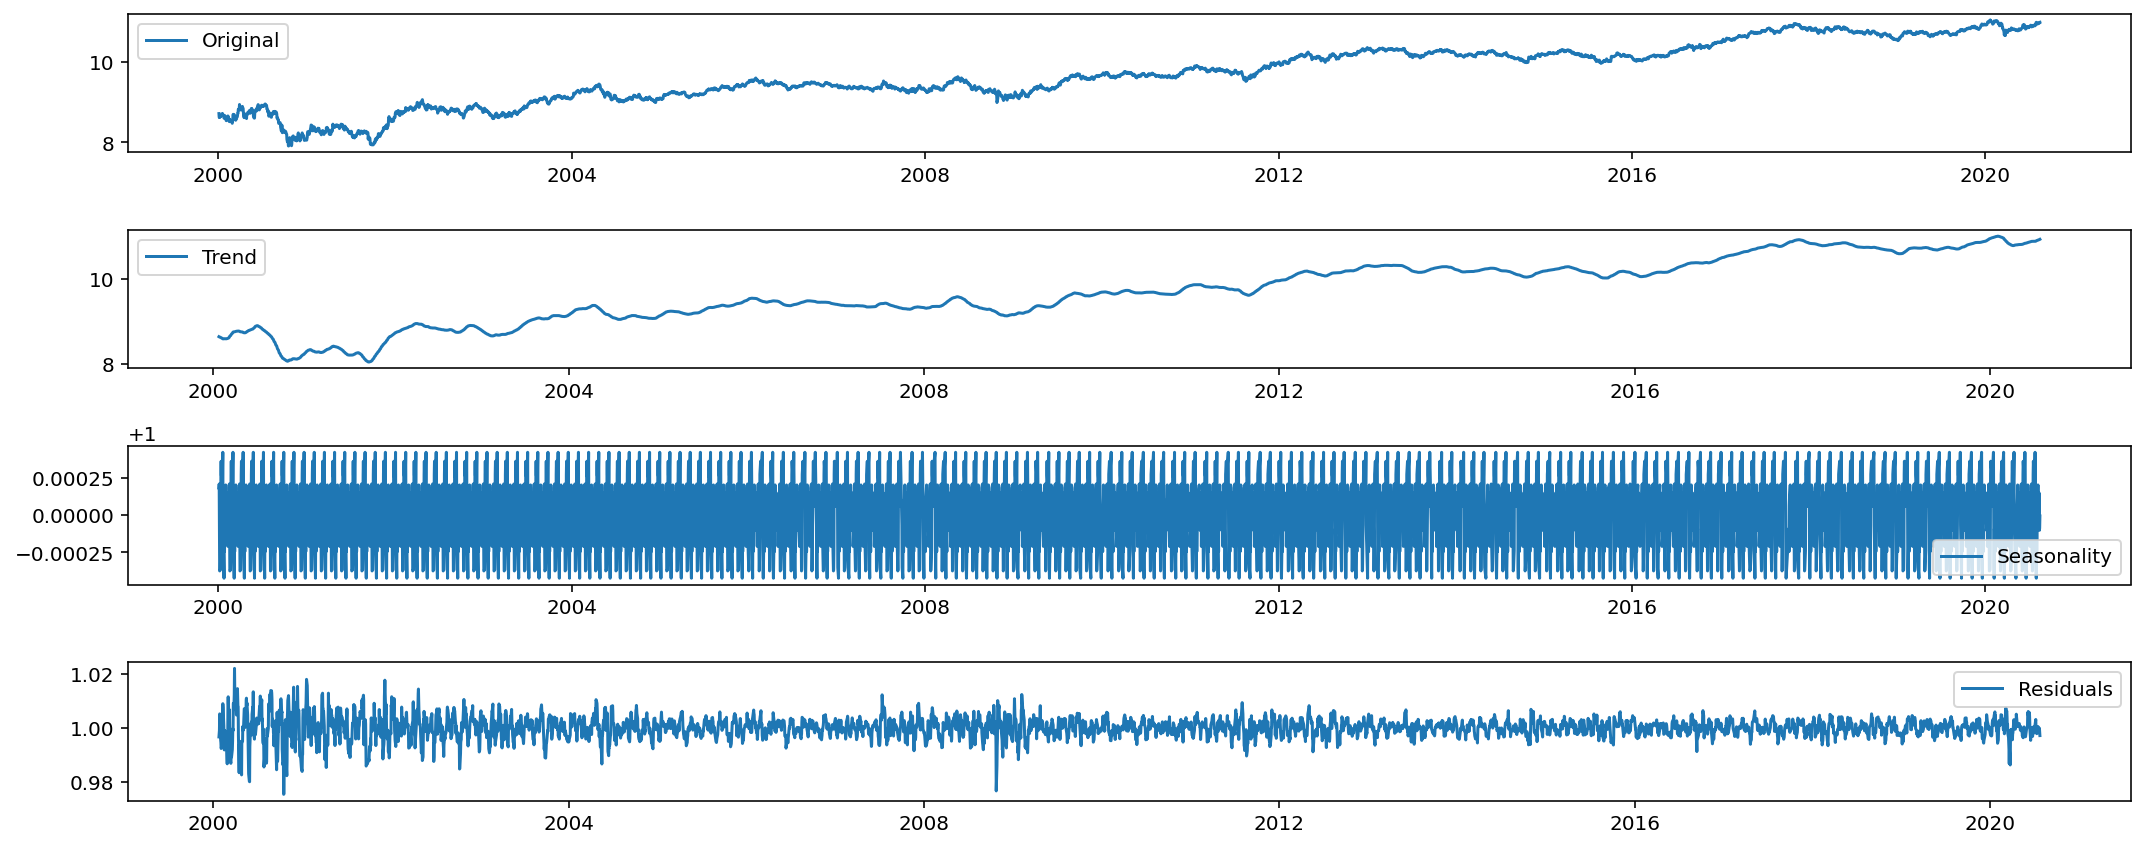

In [104]:
#시계열 분해 (Time Series Decomposition)



from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual= decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## 안정성 확인


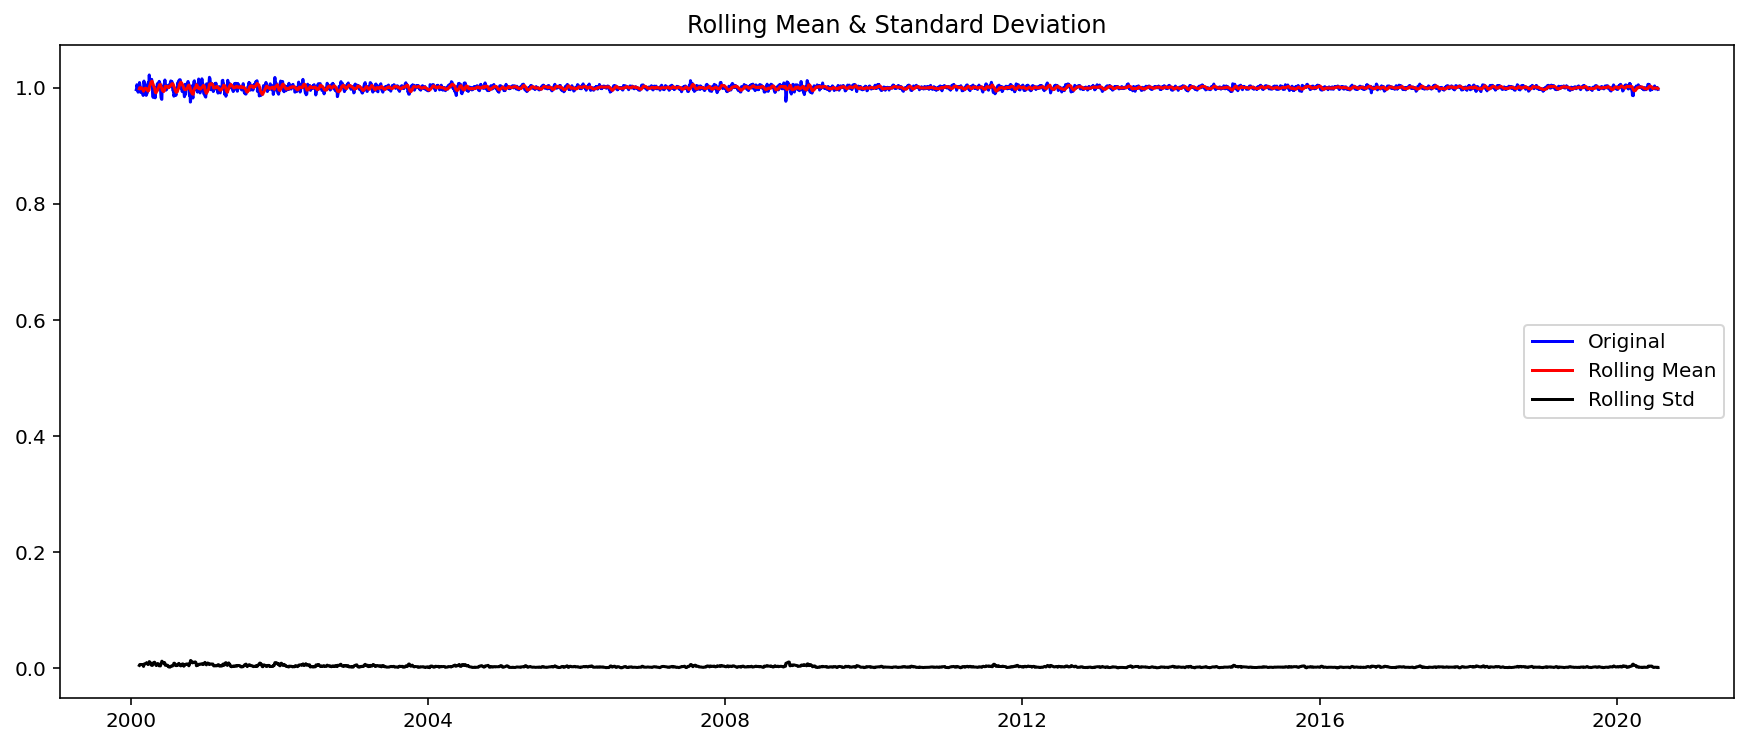

Results of Dickey-Fuller Test:
Test Statistic                -1.728530e+01
p-value                        5.748601e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


In [105]:
# Residual 로 확인
plot_rolling_statistics(residual) # 그래프
residual.dropna(inplace=True) # nan 제거
augmented_dickey_fuller_test(residual) # 귀무가설 확인

## train test data set 생성


Date
2000-01-04    8.717682
2000-01-05    8.626944
Name: Close, dtype: float64
(4668,)
(519,)


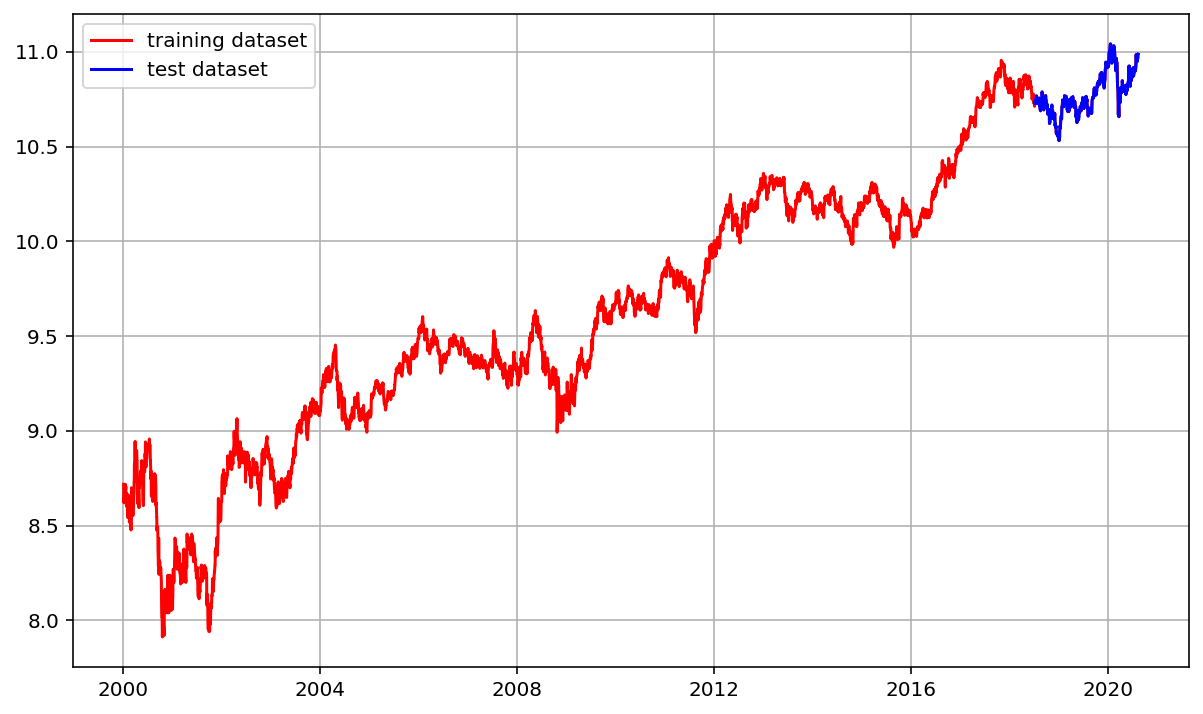

In [110]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# data set check
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

## ARIMA 모수 찾기

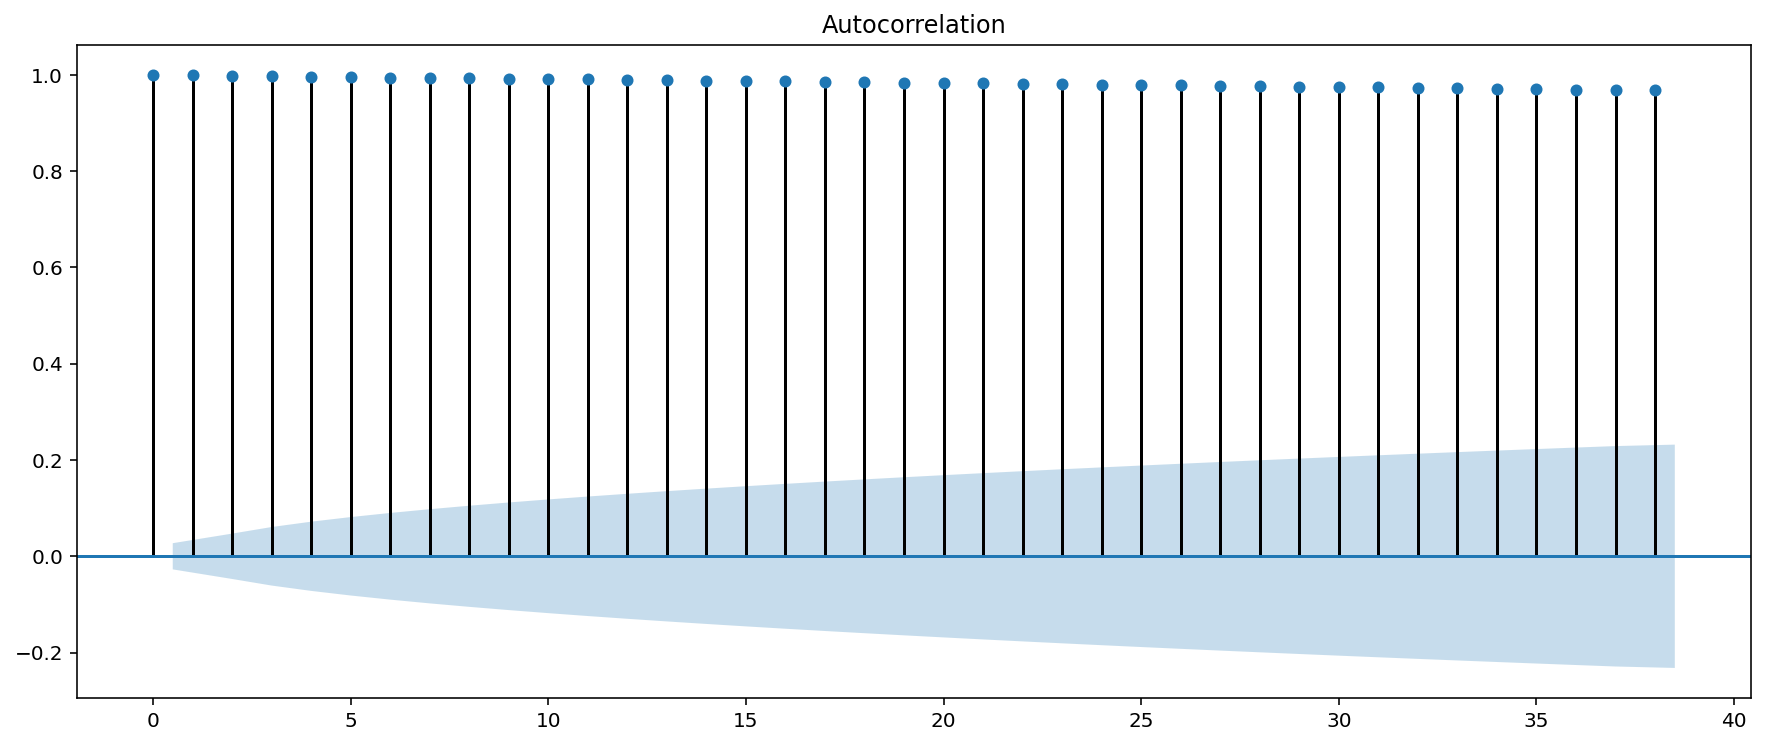

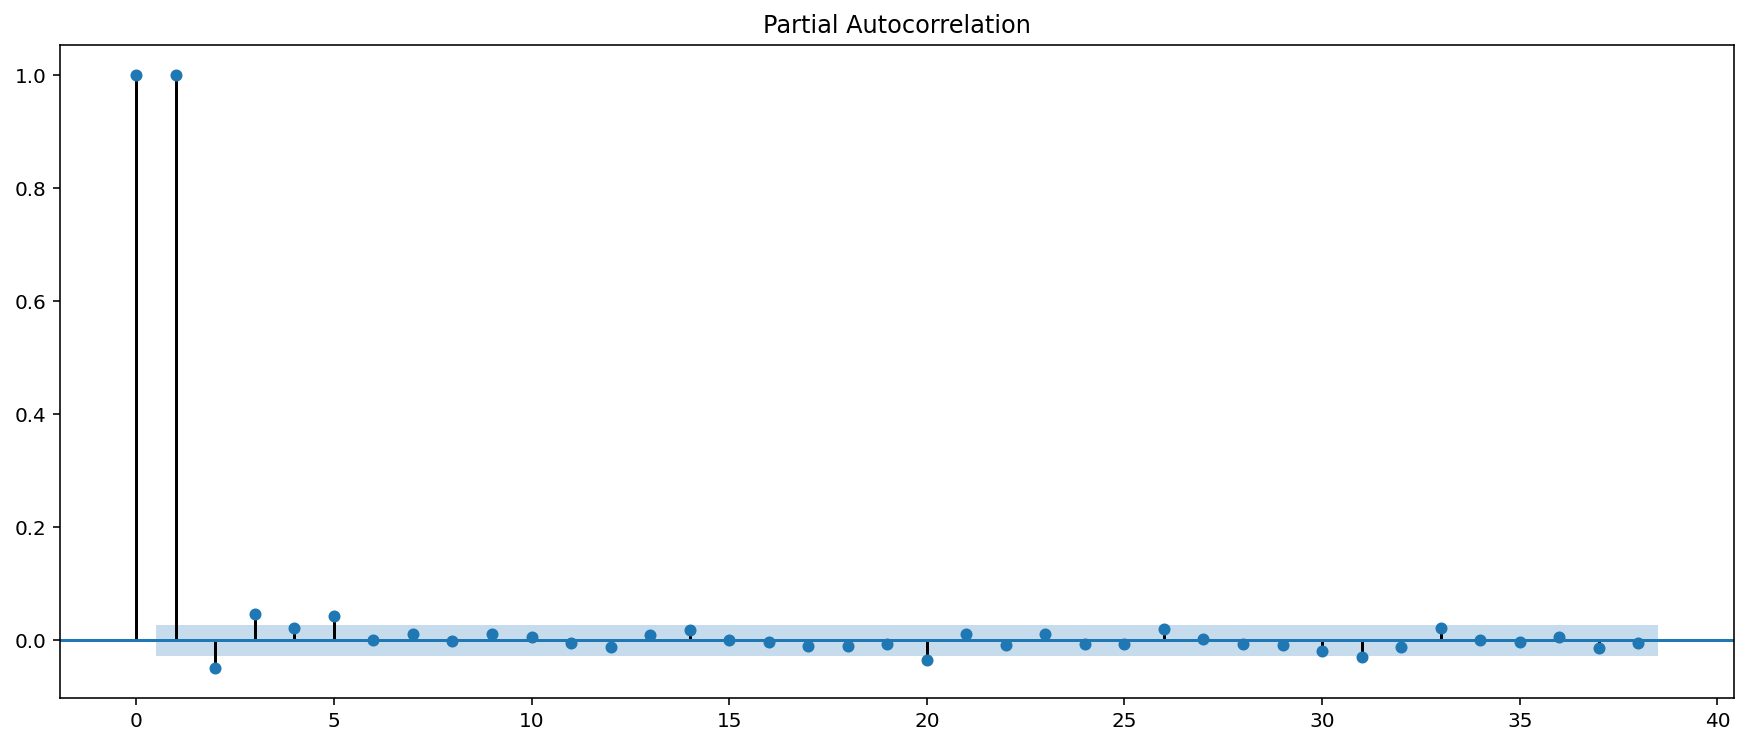

In [114]:

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# P:2 q : 0 

Results of Dickey-Fuller Test:
Test Statistic                  -39.816723
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


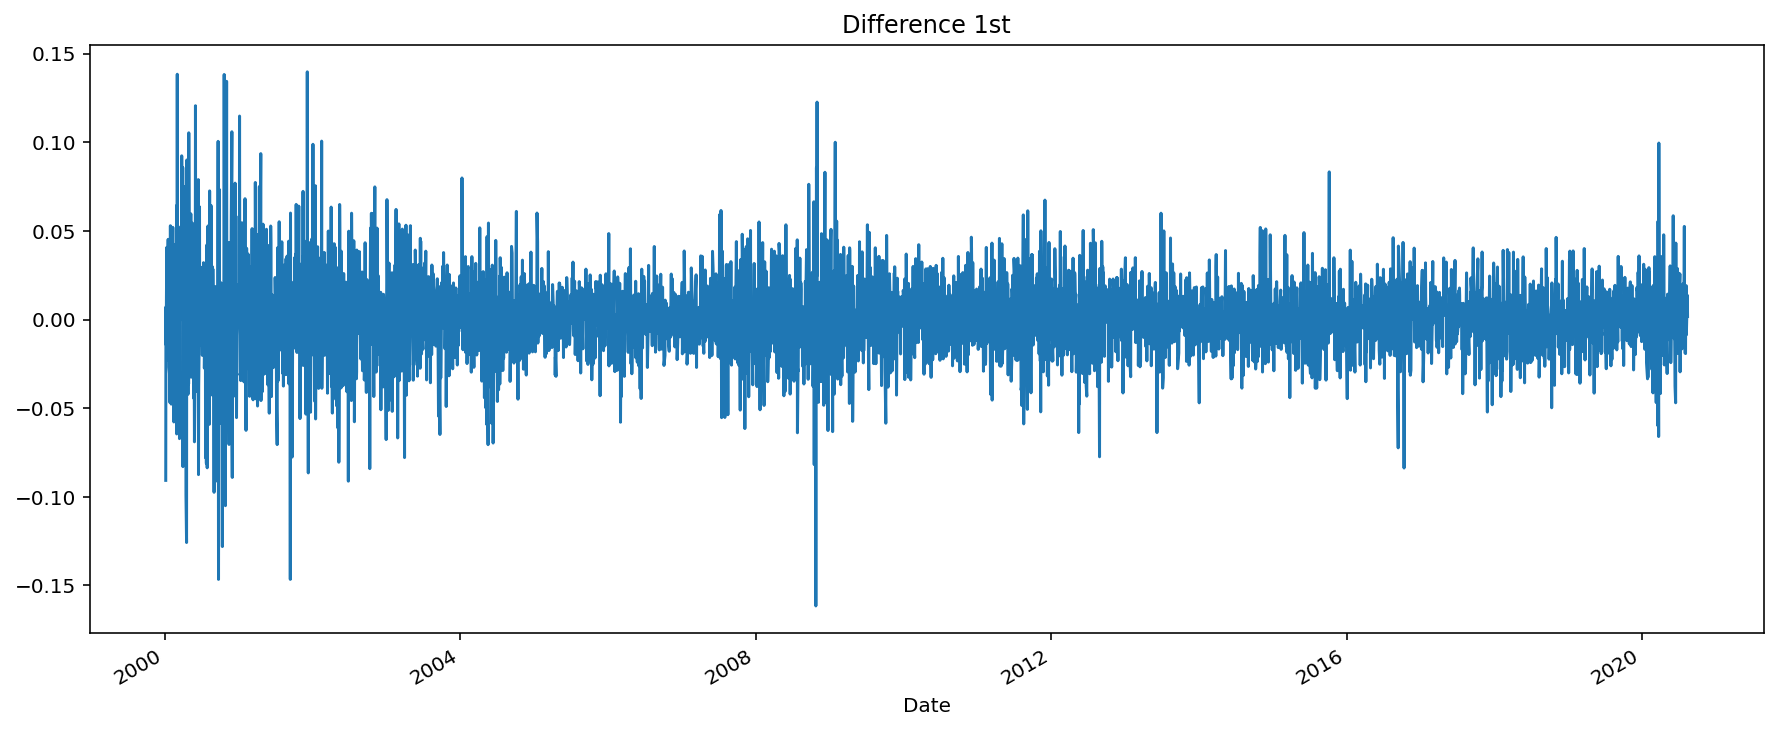

In [115]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Date
2000-01-06    0.097881
2000-01-07   -0.021480
2000-01-10    0.055015
2000-01-11   -0.040678
2000-01-12   -0.008703
                ...   
2020-08-07   -0.027806
2020-08-10    0.013862
2020-08-11    0.001693
2020-08-12    0.006756
2020-08-13   -0.011959
Name: Close, Length: 5185, dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.583101
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5151.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


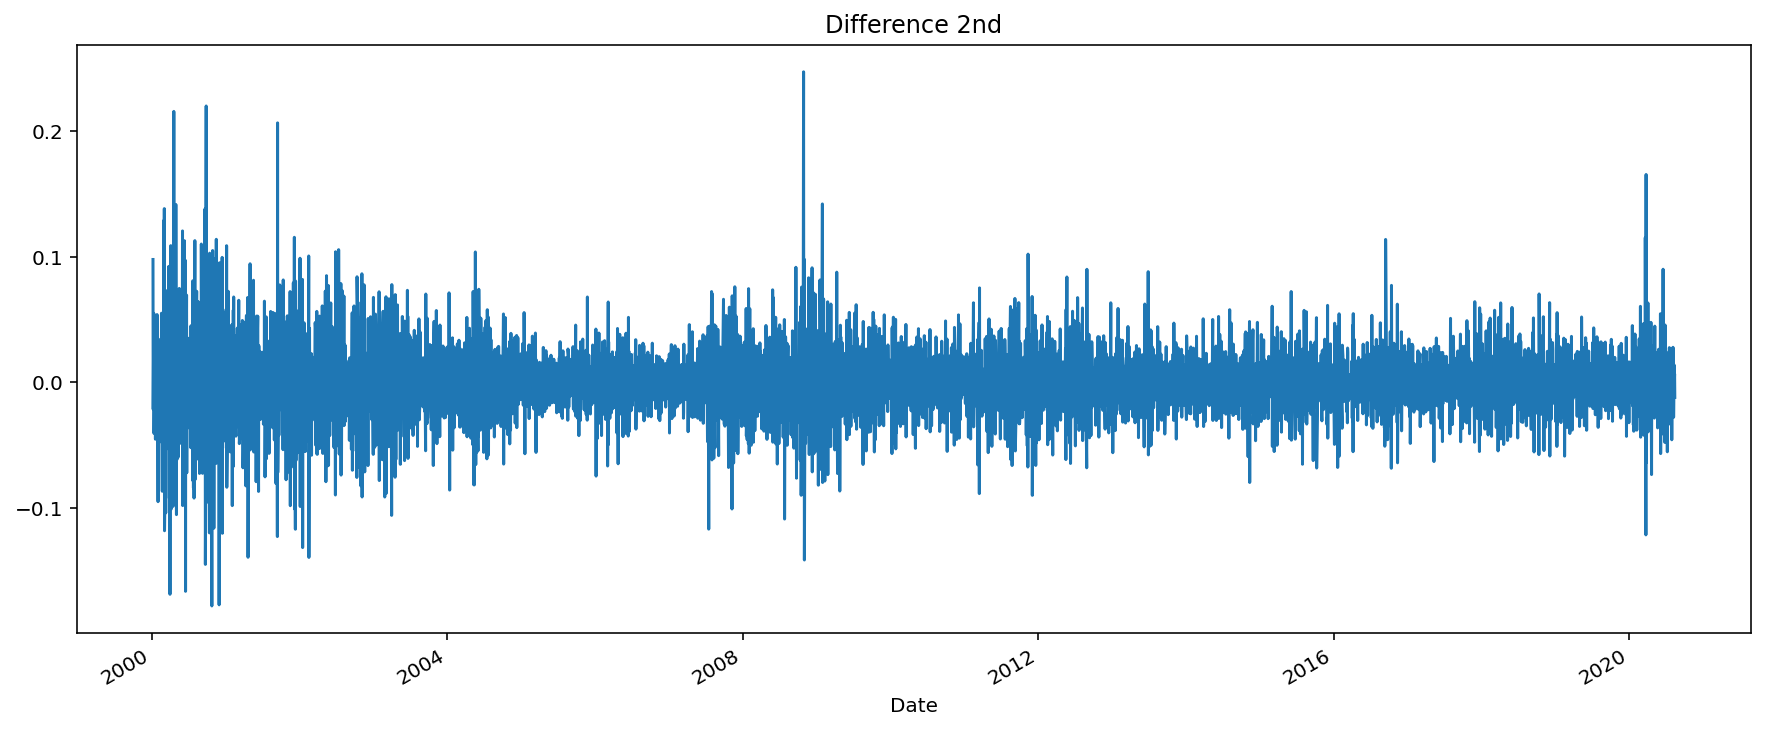

In [116]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
print(diff_2)
diff_2.plot(title='Difference 2nd')


augmented_dickey_fuller_test(diff_2)

# d=1

## ARIMA 모델 훈련과 테스트

In [142]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 1, 1))
fit_model = model.fit(disp=-1)
print(fit_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(0, 1, 1)   Log Likelihood               10984.166
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Aug 2020   AIC                         -21962.331
Time:                        16:11:27   BIC                         -21942.986
Sample:                             1   HQIC                        -21955.528
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.199      0.231      -0.000       0.001
ma.L1.D.Close     0.0555      0.016      3.536      0.000       0.025       0.086
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


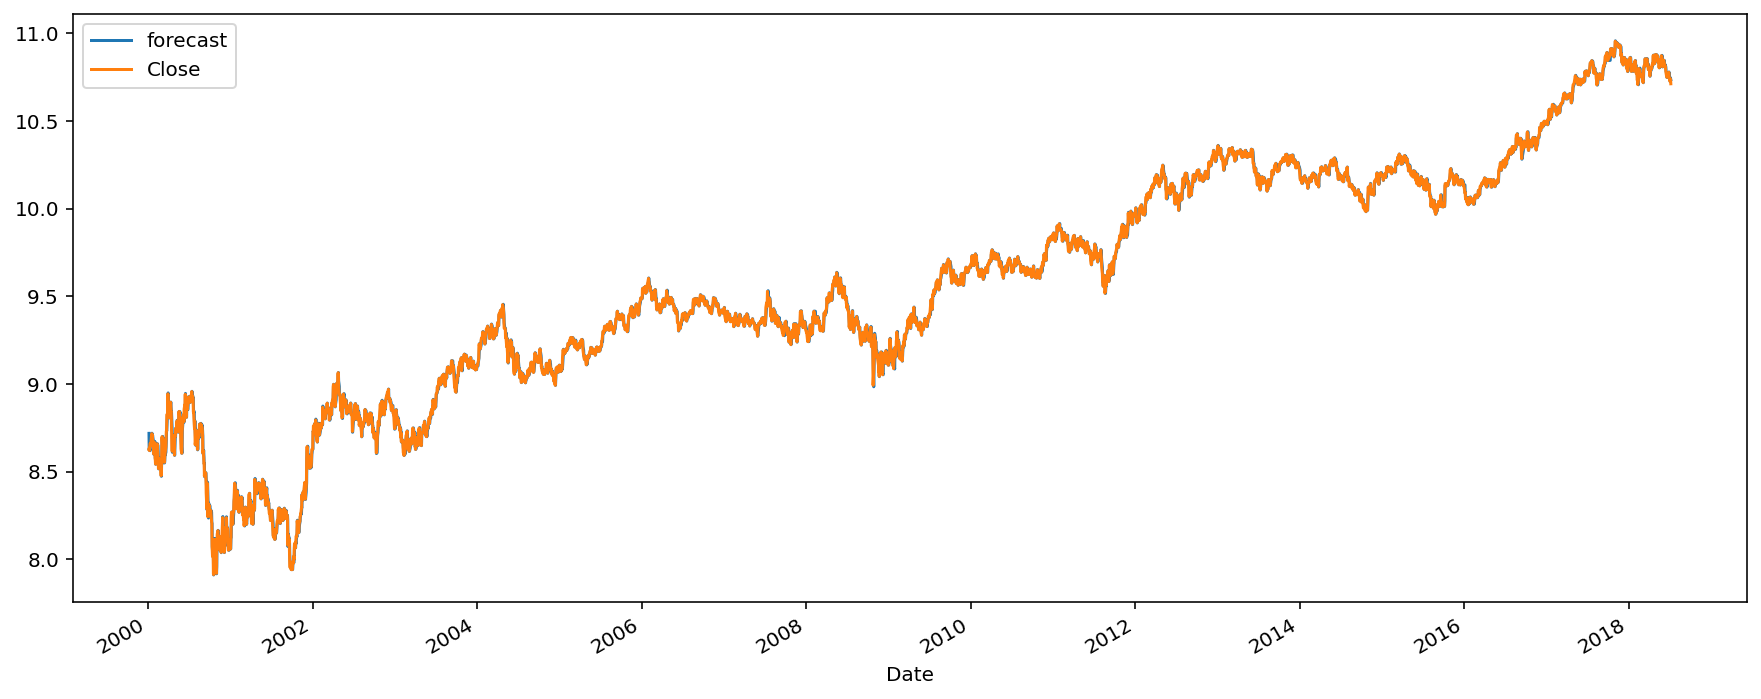

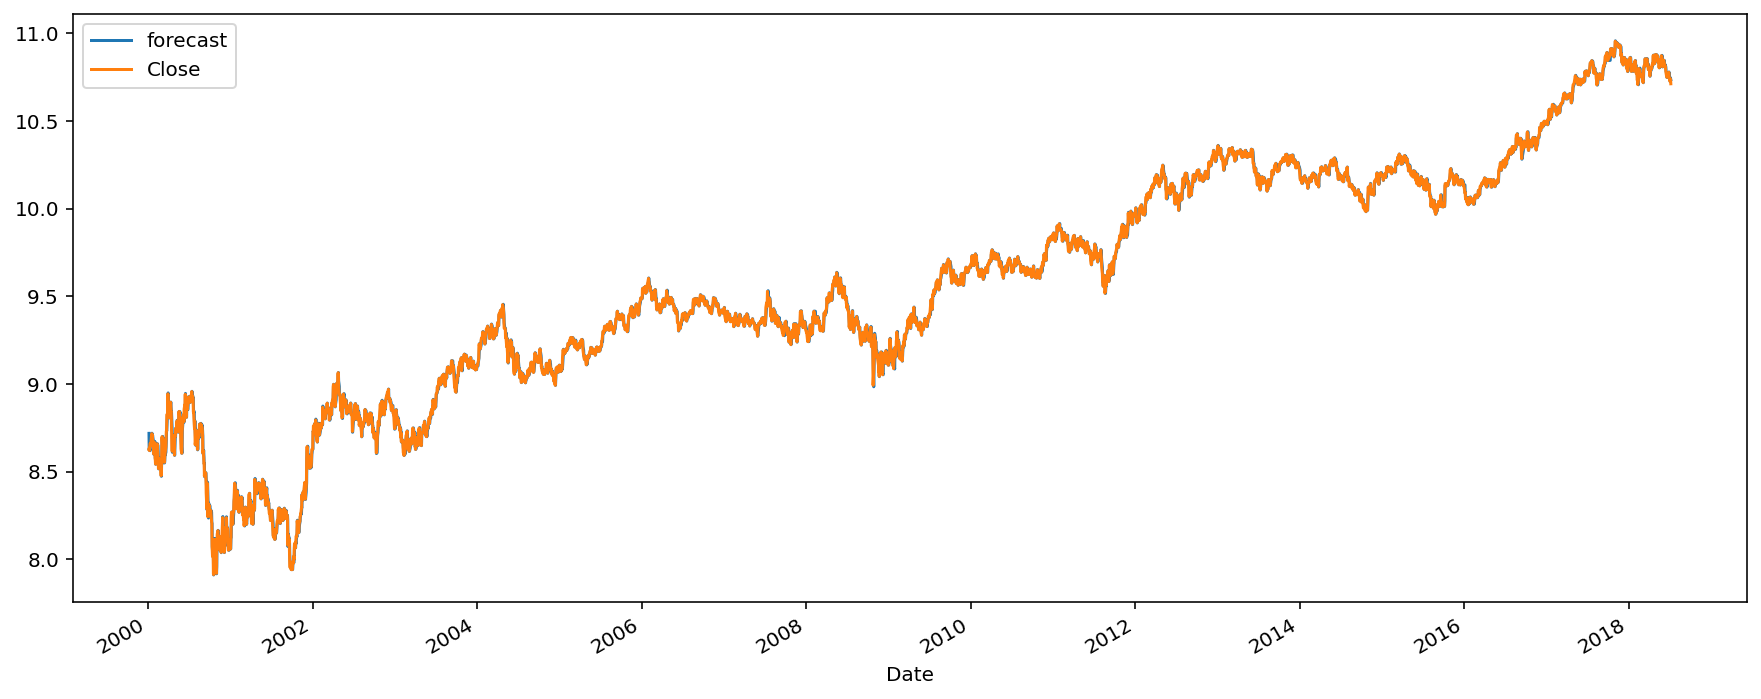

In [143]:
fit_model.plot_predict()

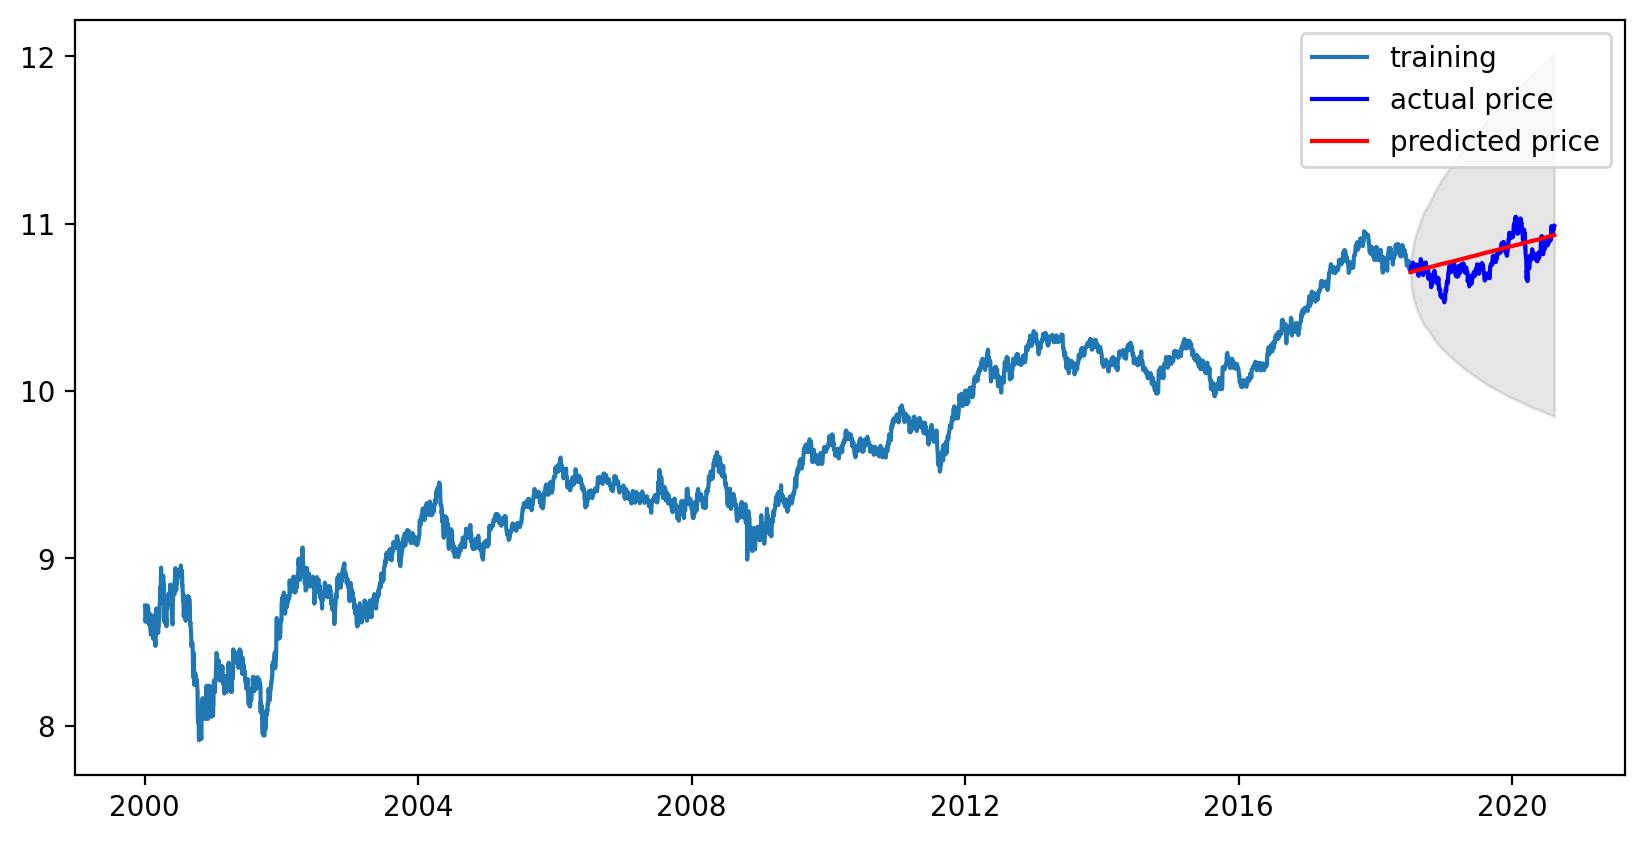

In [144]:
# 데이터 구간
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fit_model.forecast(len(test_data), alpha=0.05)  # 95% conf
#   step , 
# alpha 


# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [145]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18495545.853779193
MAE:  3587.6464982139028
RMSE:  4300.644818370752
MAPE: 7.68%


## 다른 예제(1) - 아시아나 항공

In [233]:
#data import
#file_path_asiana = './data/asiana_airlines.csv'
file_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/E06-Stationary_Time_Series/data/asiana_airlines.csv' 

asiana = pd.read_csv(file_path_asiana, index_col="Date", parse_dates=True)
asiana.head()


Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-05-18  42.049999  45.000000  38.000000  38.230000  38.230000  573576400
2012-05-21  36.529999  36.660000  33.000000  34.029999  34.029999  168192700
2012-05-22  32.610001  33.590000  30.940001  31.000000  31.000000  101786600
2012-05-23  31.370001  32.500000  31.360001  32.000000  32.000000   73600000
2012-05-24  32.950001  33.209999  31.770000  33.029999  33.029999   50237200

In [234]:
#series object exprot
asiana_s = asiana['Close']
asiana_s.head()

Date
2012-05-18    38.230000
2012-05-21    34.029999
2012-05-22    31.000000
2012-05-23    32.000000
2012-05-24    33.029999
Name: Close, dtype: float64

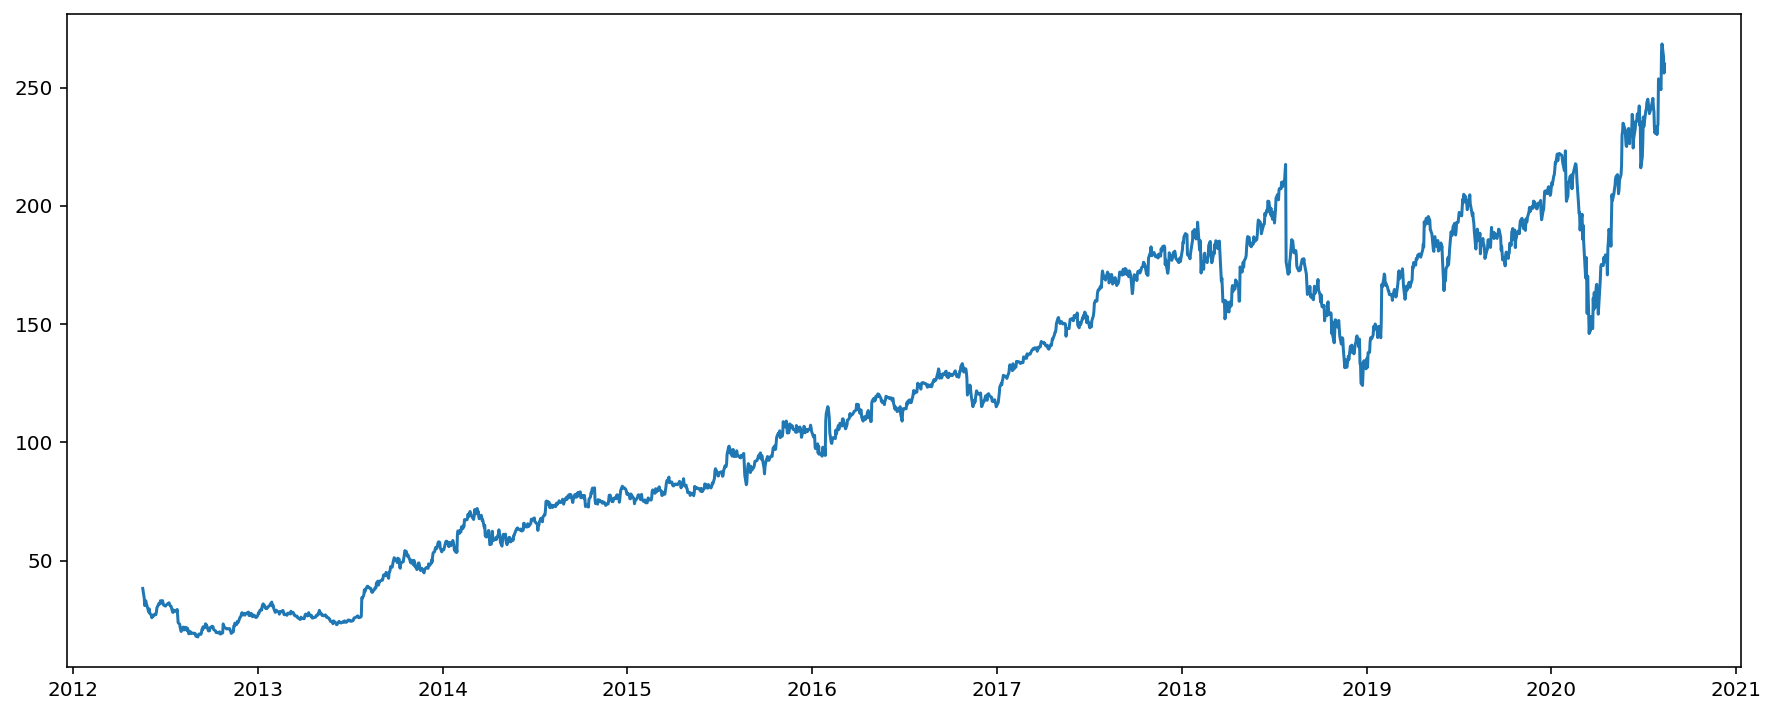

In [235]:
#전처리

asiana_s = asiana_s.interpolate(method="time")
asiana_s[asiana_s.isna()]
plt.plot(asiana_s)

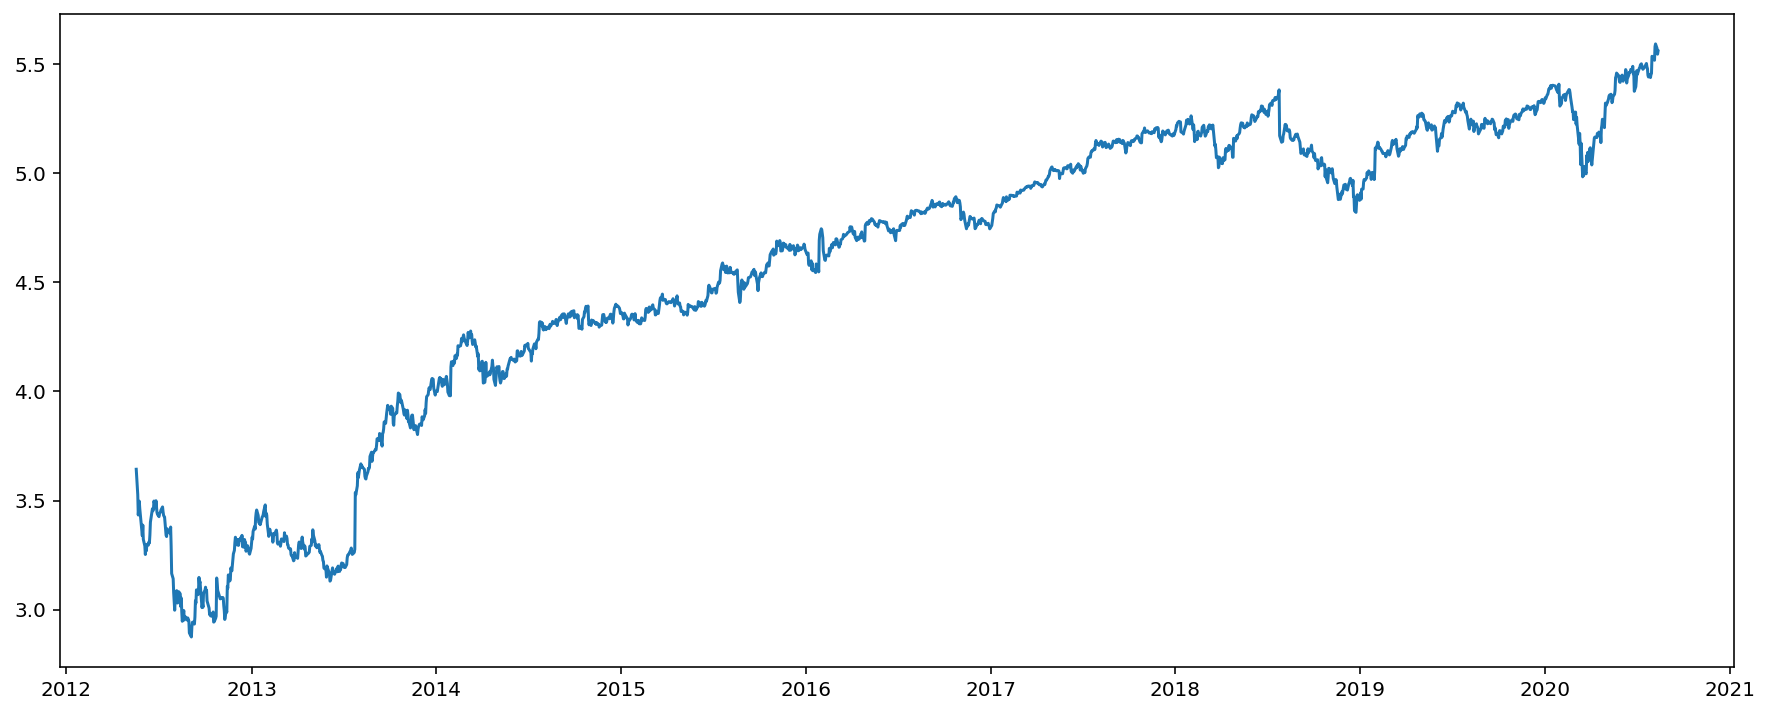

In [236]:
# 로그 함수 씌우기
asiana_s_log = np.log(asiana_s)
plt.plot(asiana_s_log)

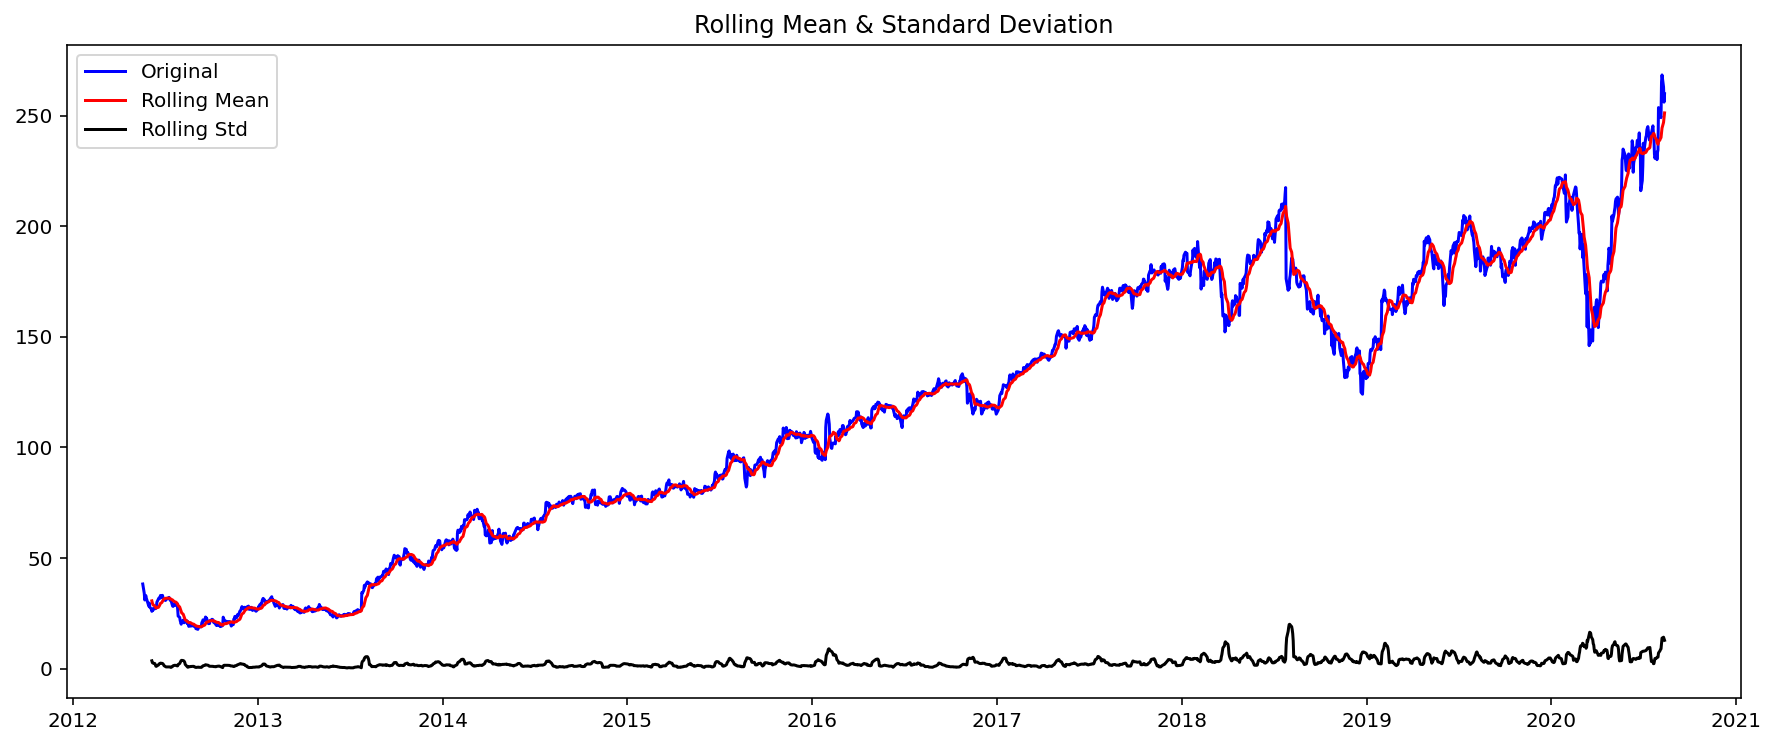

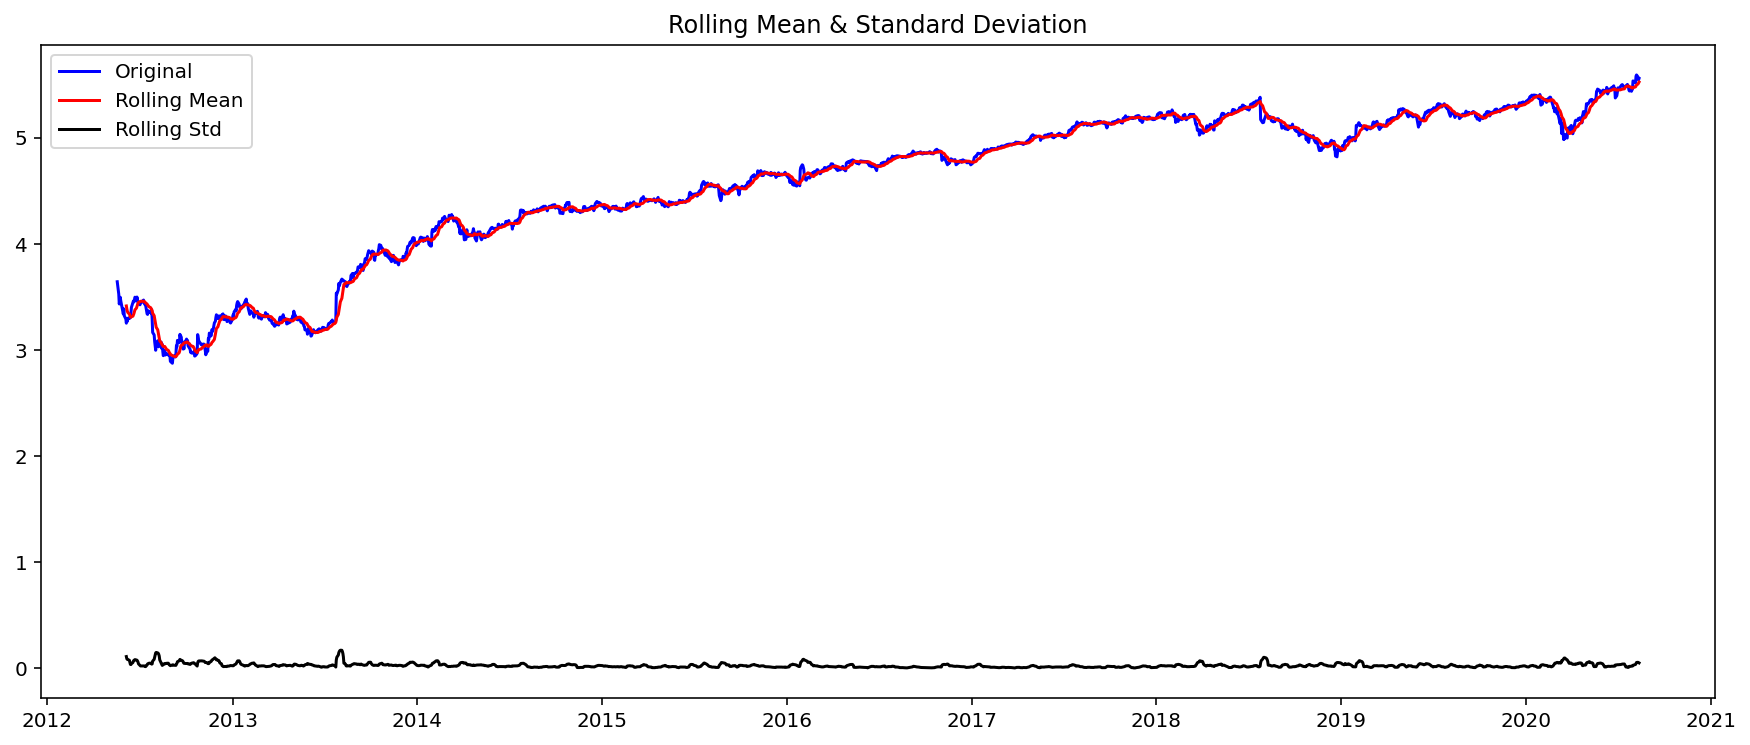

In [237]:
#
#로그 전.
plot_rolling_statistics(asiana_s, window=12)
# 로그 후.
plot_rolling_statistics(asiana_s_log, window=12)

In [238]:
augmented_dickey_fuller_test(asiana_s_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.182537
p-value                           0.681062
#Lags Used                       10.000000
Number of Observations Used    2061.000000
Critical Value (1%)              -3.433527
Critical Value (5%)              -2.862943
Critical Value (10%)             -2.567517
dtype: float64


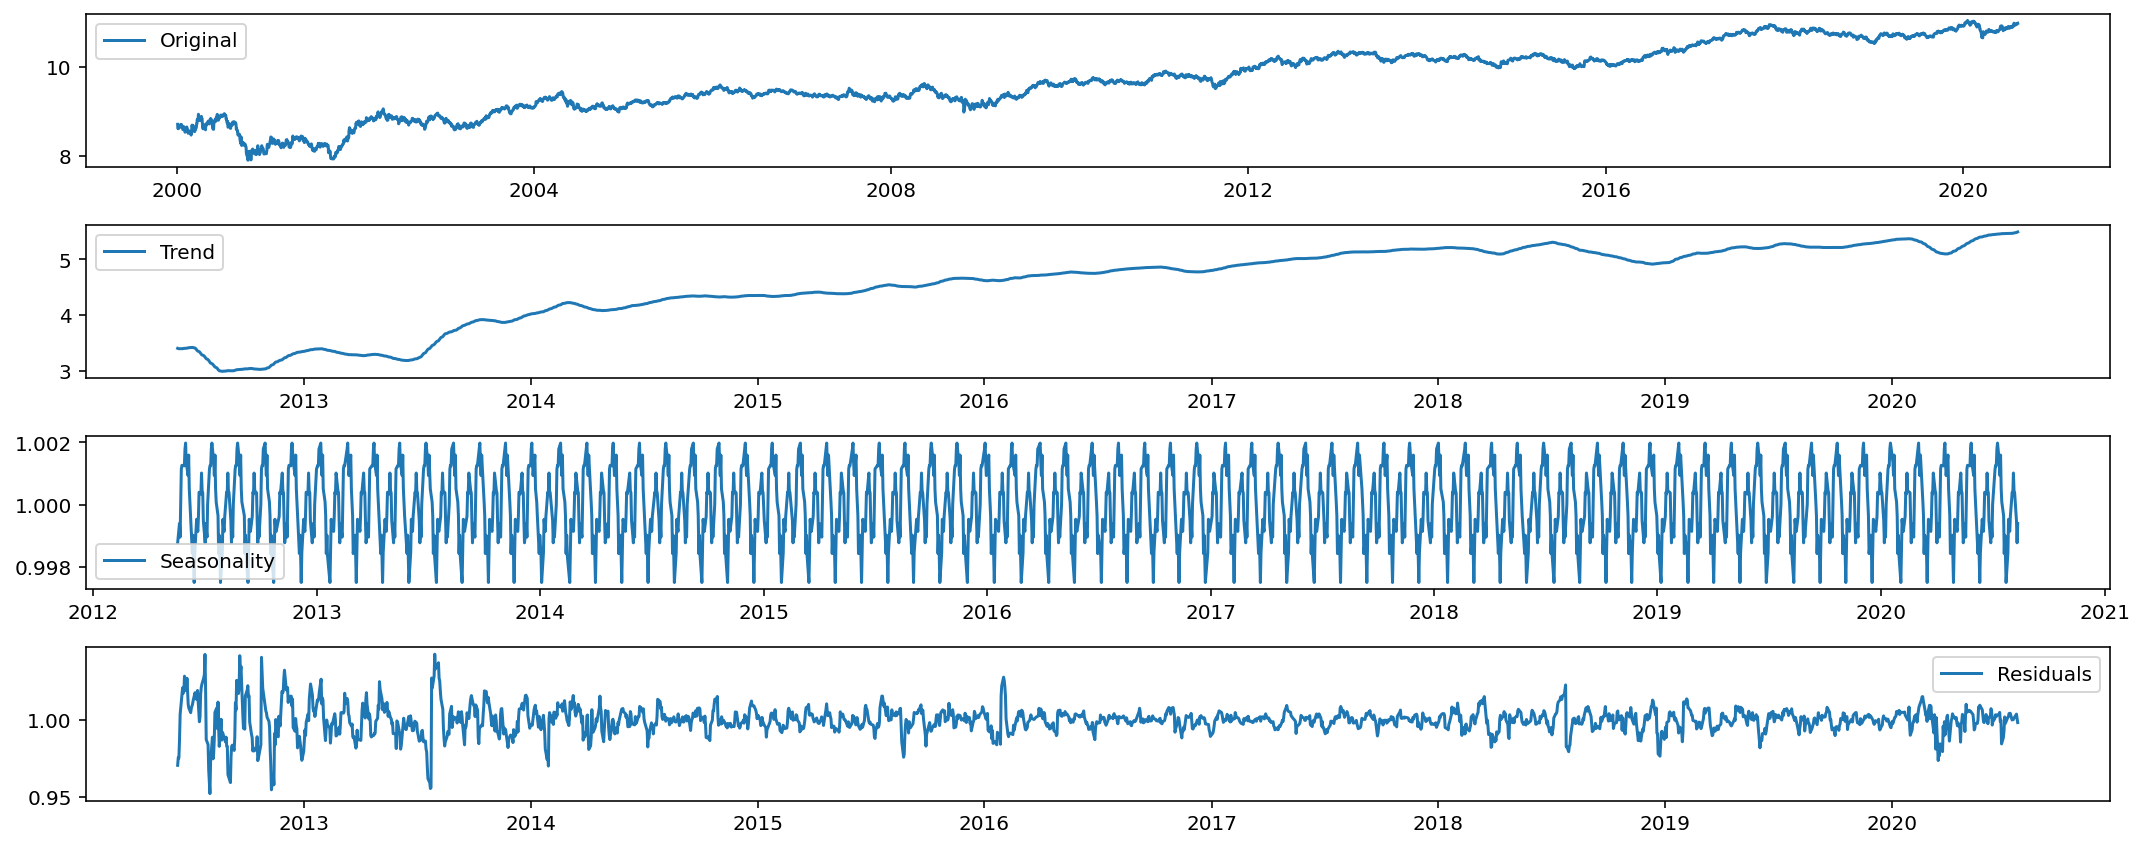

In [239]:
# 시계열 분석

decomposition = seasonal_decompose(asiana_s_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual= decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

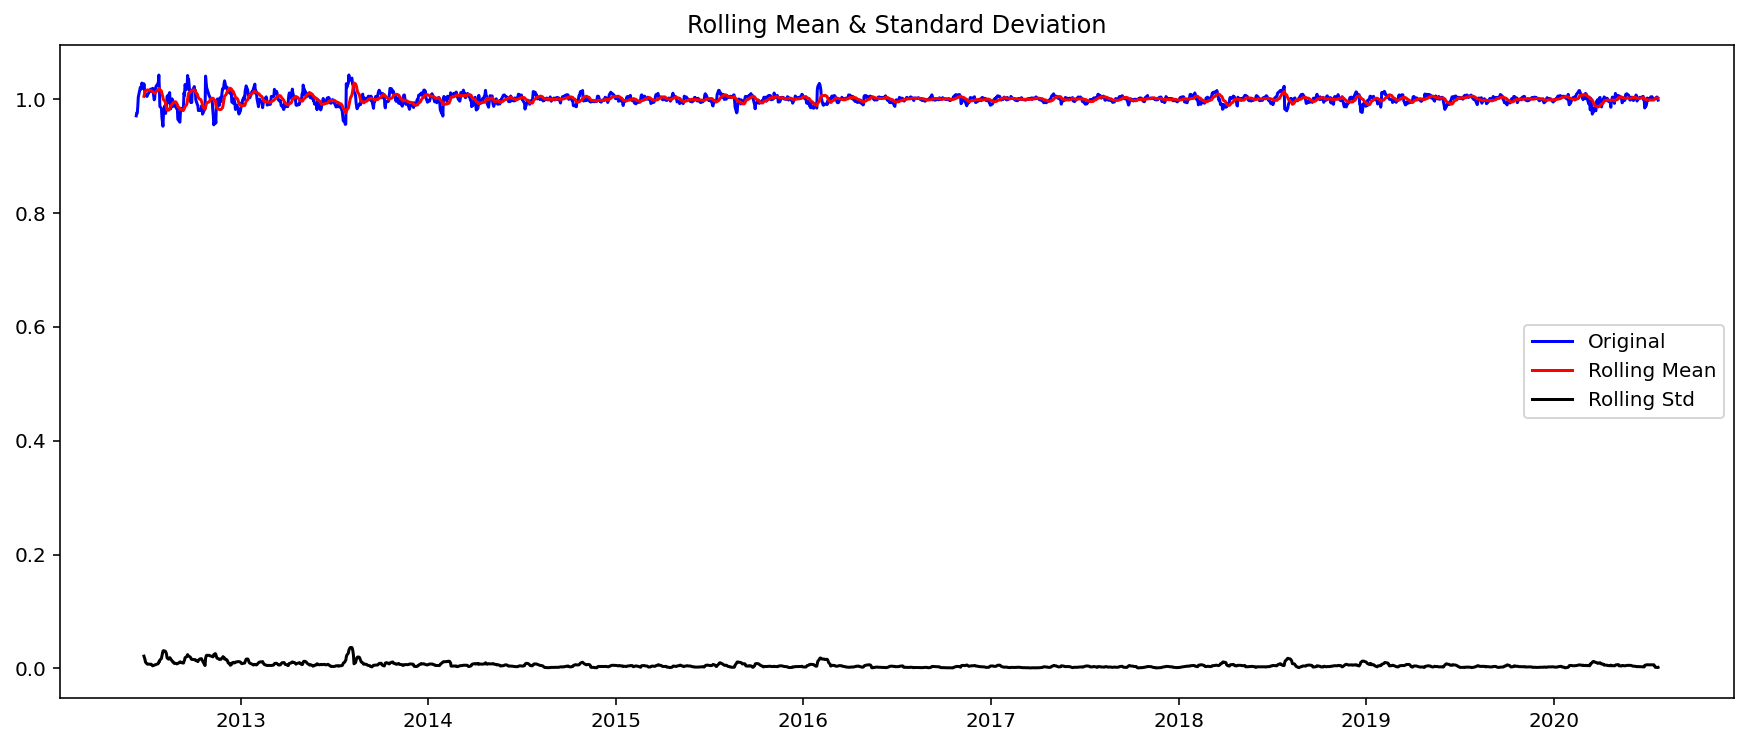

Results of Dickey-Fuller Test:
Test Statistic                -1.183524e+01
p-value                        7.818997e-22
#Lags Used                     2.600000e+01
Number of Observations Used    2.015000e+03
Critical Value (1%)           -3.433599e+00
Critical Value (5%)           -2.862975e+00
Critical Value (10%)          -2.567534e+00
dtype: float64


In [240]:
# 안정성 확인
# Residual 로 확인
plot_rolling_statistics(residual) # 그래프
residual.dropna(inplace=True) # nan 제거
augmented_dickey_fuller_test(residual) # 귀무가설 확인

Date
2012-05-18    3.643621
2012-05-21    3.527242
Name: Close, dtype: float64
(1864,)
(208,)


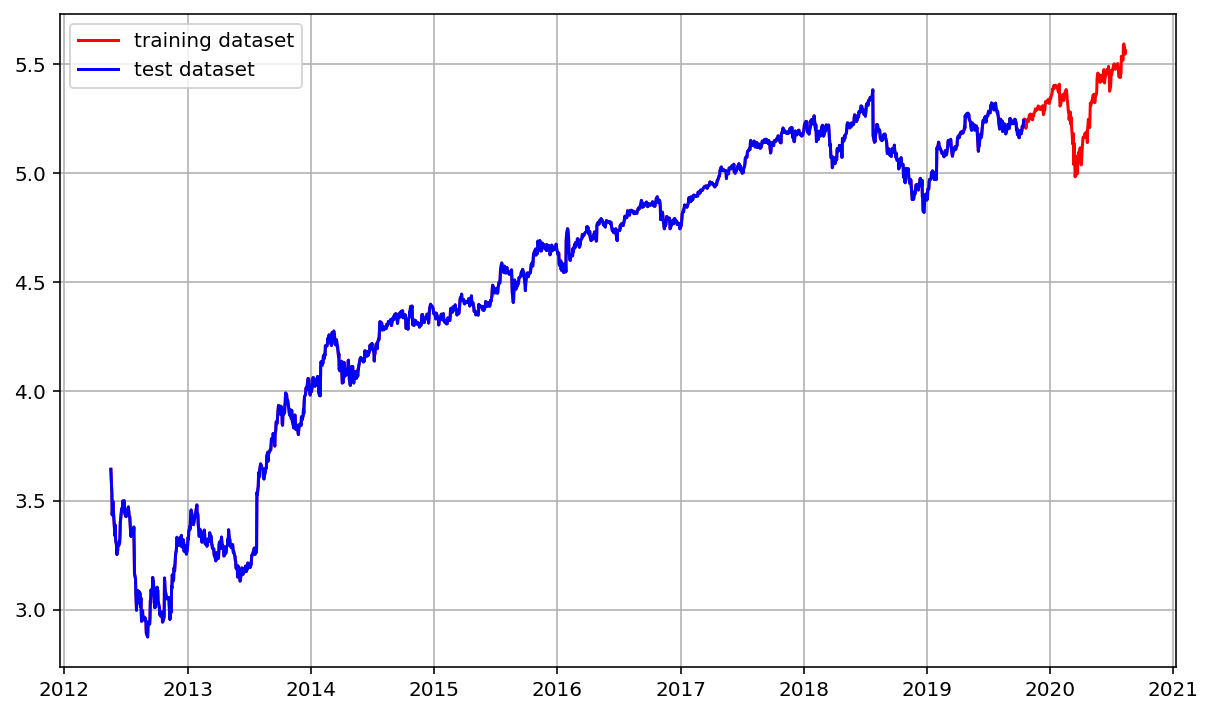

In [241]:
# train, test data spilt
train_a_data, test_a_data = asiana_s_log[:int(len(asiana_s_log)*0.9)], asiana_s_log[int(len(asiana_s_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(asiana_s_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(train_a_data, c='b', label='test dataset')
plt.legend()

# data set check
print(asiana_s_log[:2])
print(train_a_data.shape)
print(test_a_data.shape)

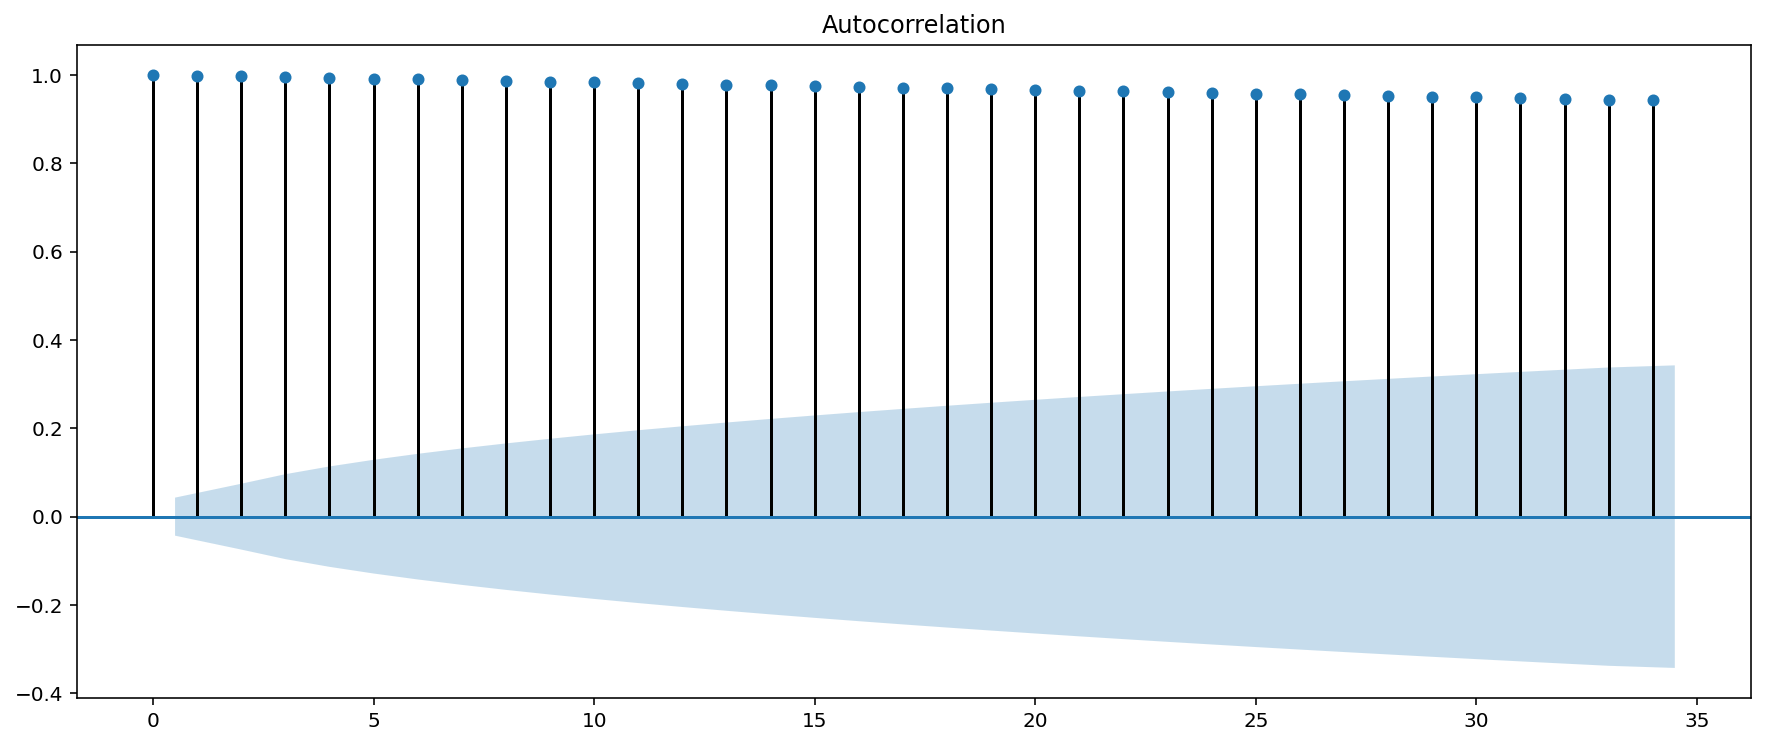

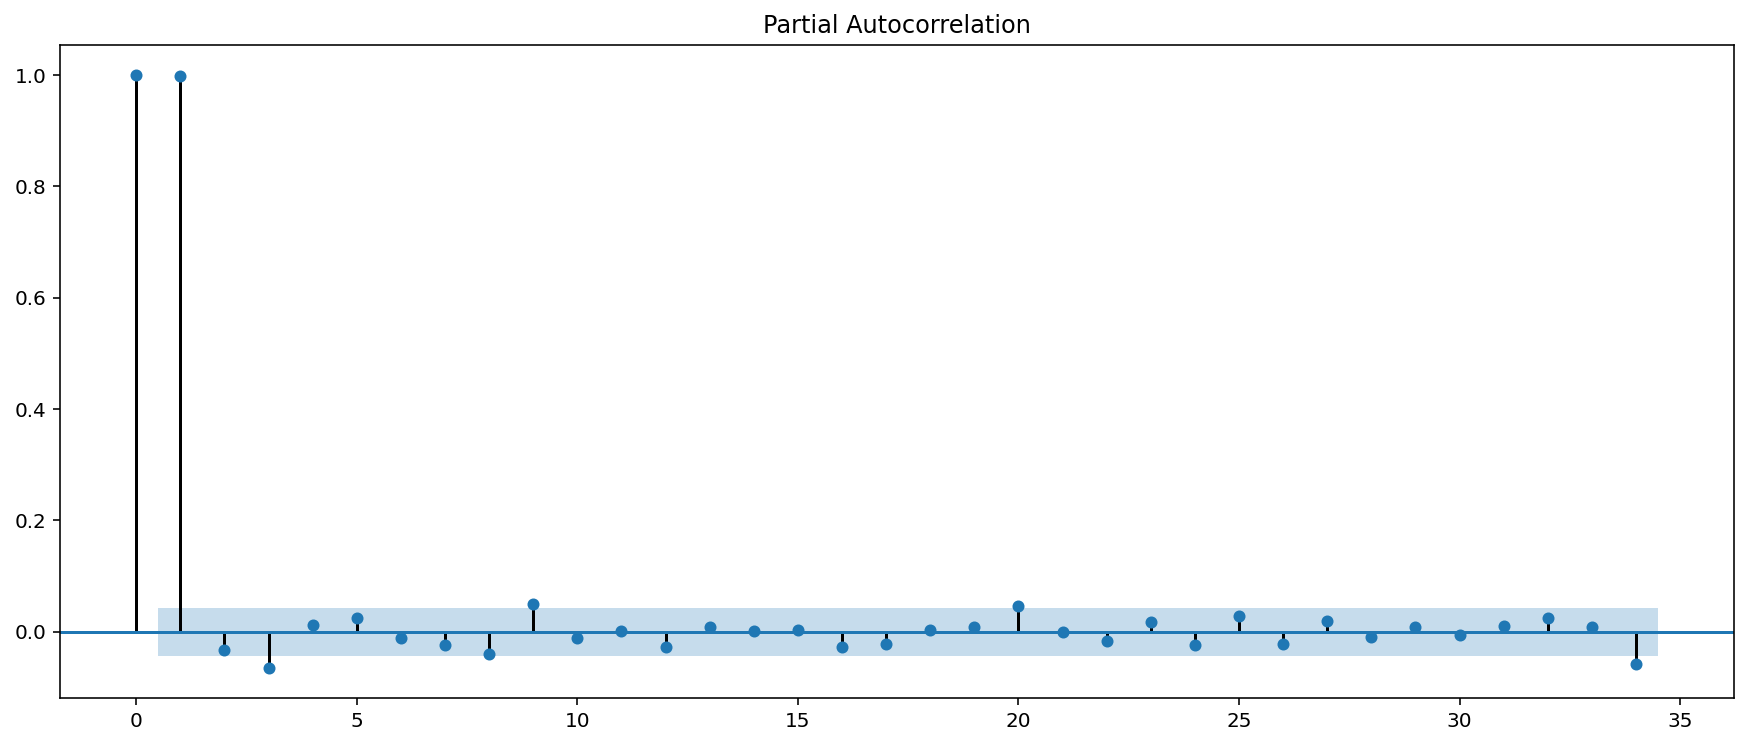

In [242]:
plot_acf(asiana_s_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(asiana_s_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.440184e+01
p-value                        8.483075e-27
#Lags Used                     1.000000e+01
Number of Observations Used    2.060000e+03
Critical Value (1%)           -3.433528e+00
Critical Value (5%)           -2.862944e+00
Critical Value (10%)          -2.567517e+00
dtype: float64


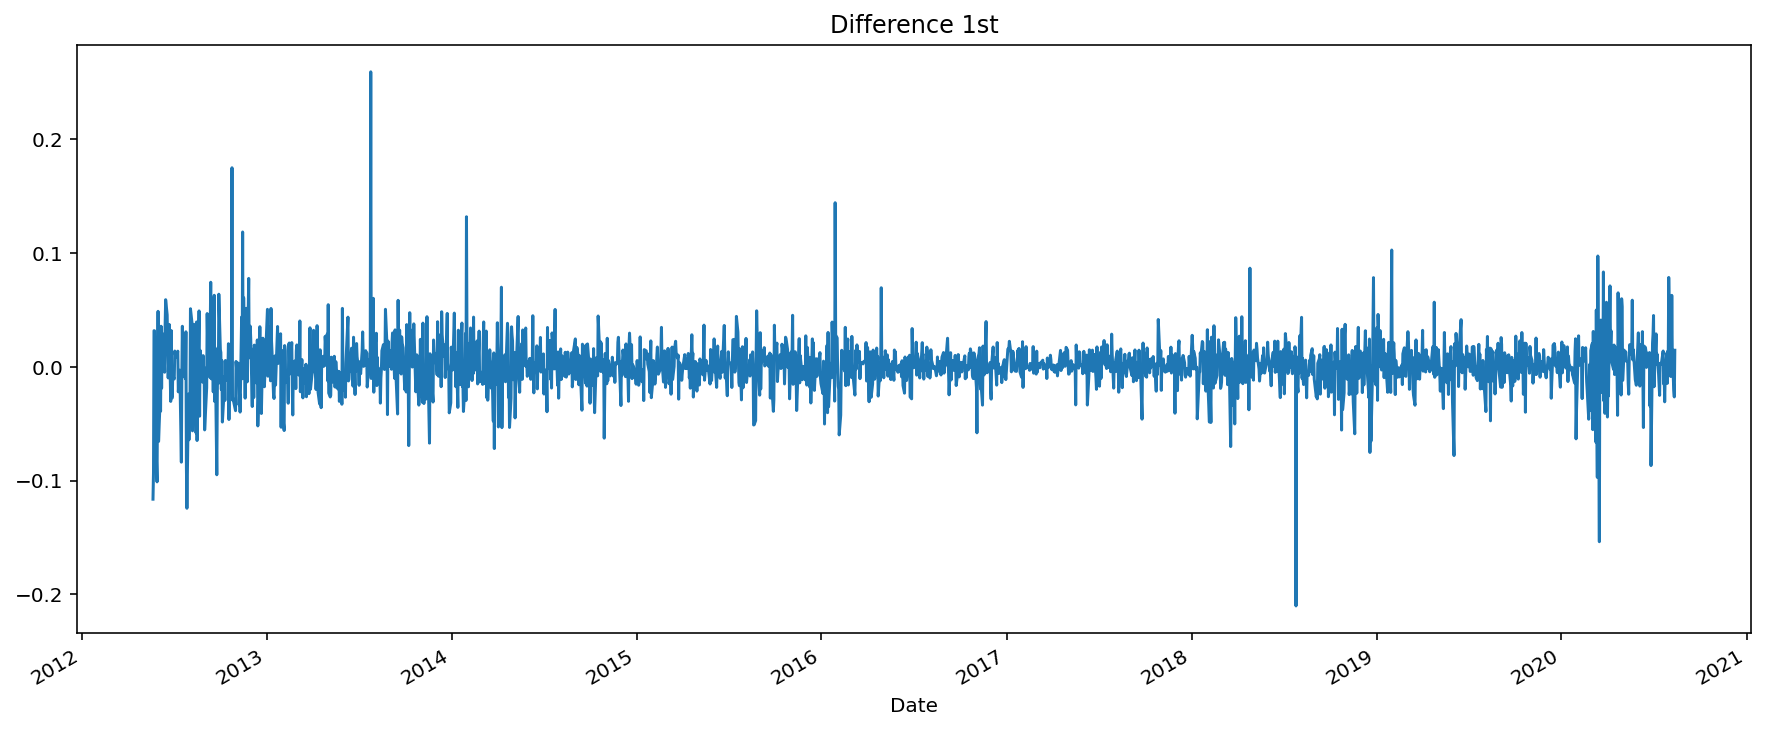

In [243]:
# 1차 차분 구하기
diff_1 = asiana_s_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [244]:
#훈련
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_a_data, order=(0, 1, 4))
fit_model = model.fit(disp=-1)
print(fit_model.summary())

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1863
Model:                 ARIMA(0, 1, 4)   Log Likelihood                4402.848
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Aug 2020   AIC                          -8793.697
Time:                        17:03:14   BIC                          -8760.517
Sample:                             1   HQIC                         -8781.470
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      1.639      0.101      -0.000       0.002
ma.L1.D.Close     0.0107      0.023      0.456      0.649      -0.035       0.057
ma.L2.D.Close    -0.0011      0.024     

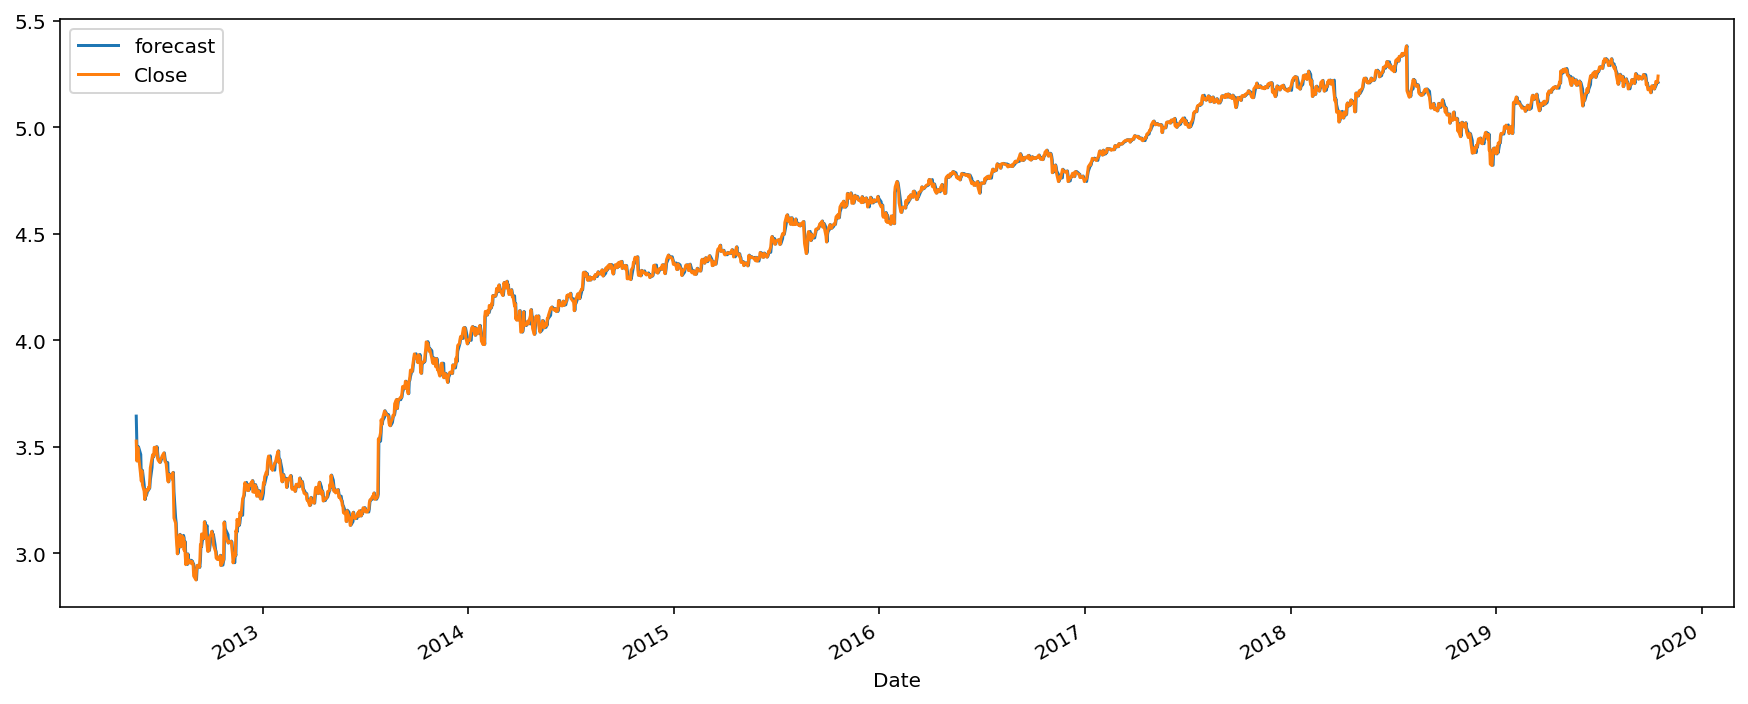

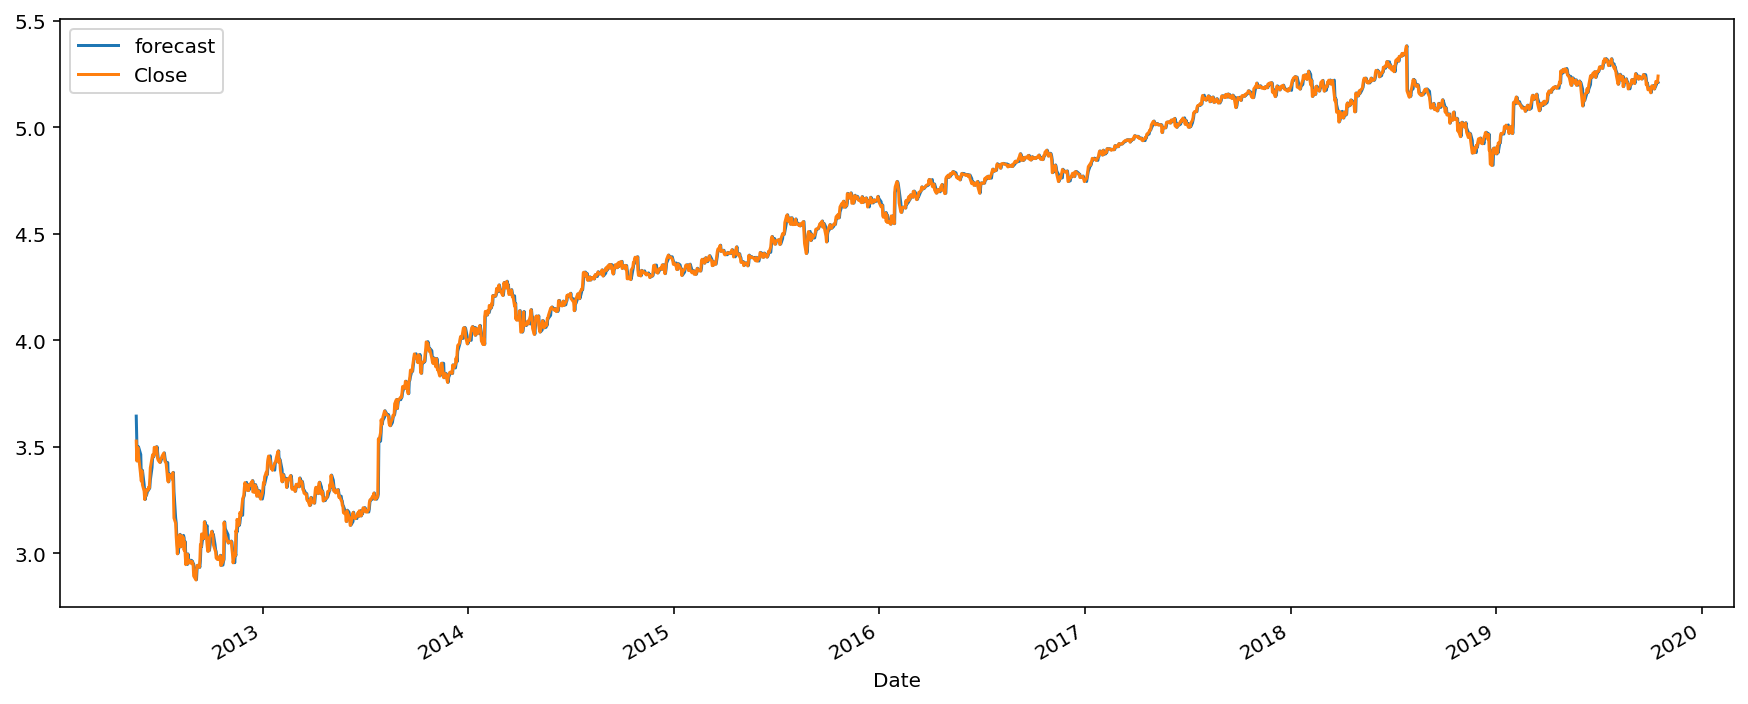

In [245]:
fit_model.plot_predict()

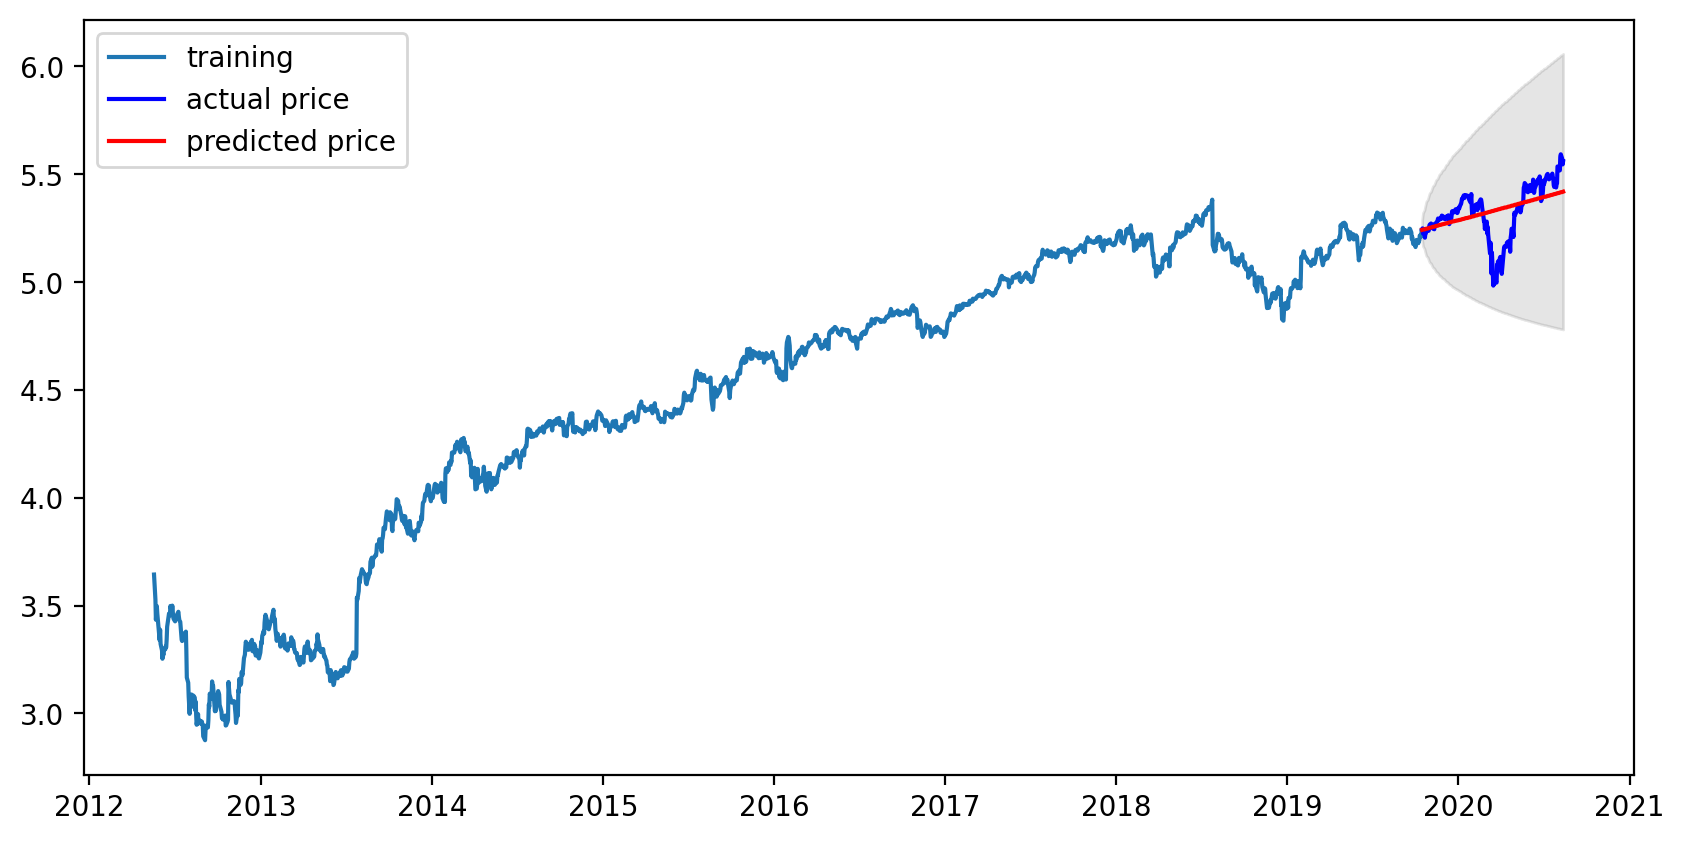

In [246]:
# 데이터 구간
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fit_model.forecast(len(test_a_data), alpha=0.05)  # 95% conf
#   step , 
# alpha 


# Make as pandas series
fc_series = pd.Series(fc, index=test_a_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_a_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_a_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_a_data, label='training')
plt.plot(test_a_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [247]:
mse = mean_squared_error(np.exp(test_a_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_a_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_a_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_a_data))/np.abs(np.exp(test_a_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  487.11039486483514
MAE:  16.71725420392465
RMSE:  22.070577583399015
MAPE: 8.65%


## 다른 예제(2) - 페이스북

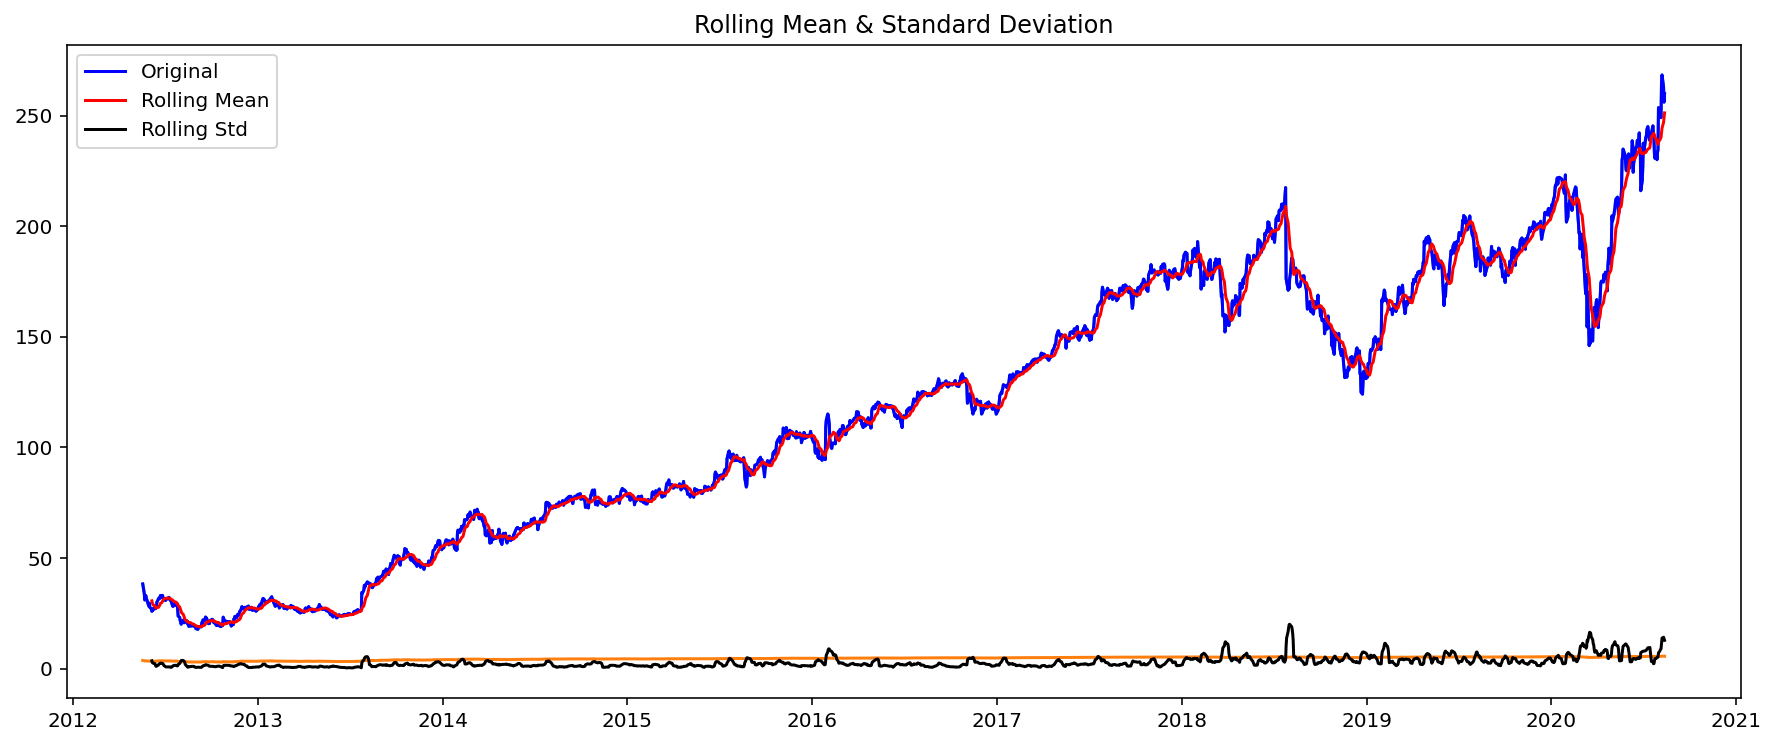

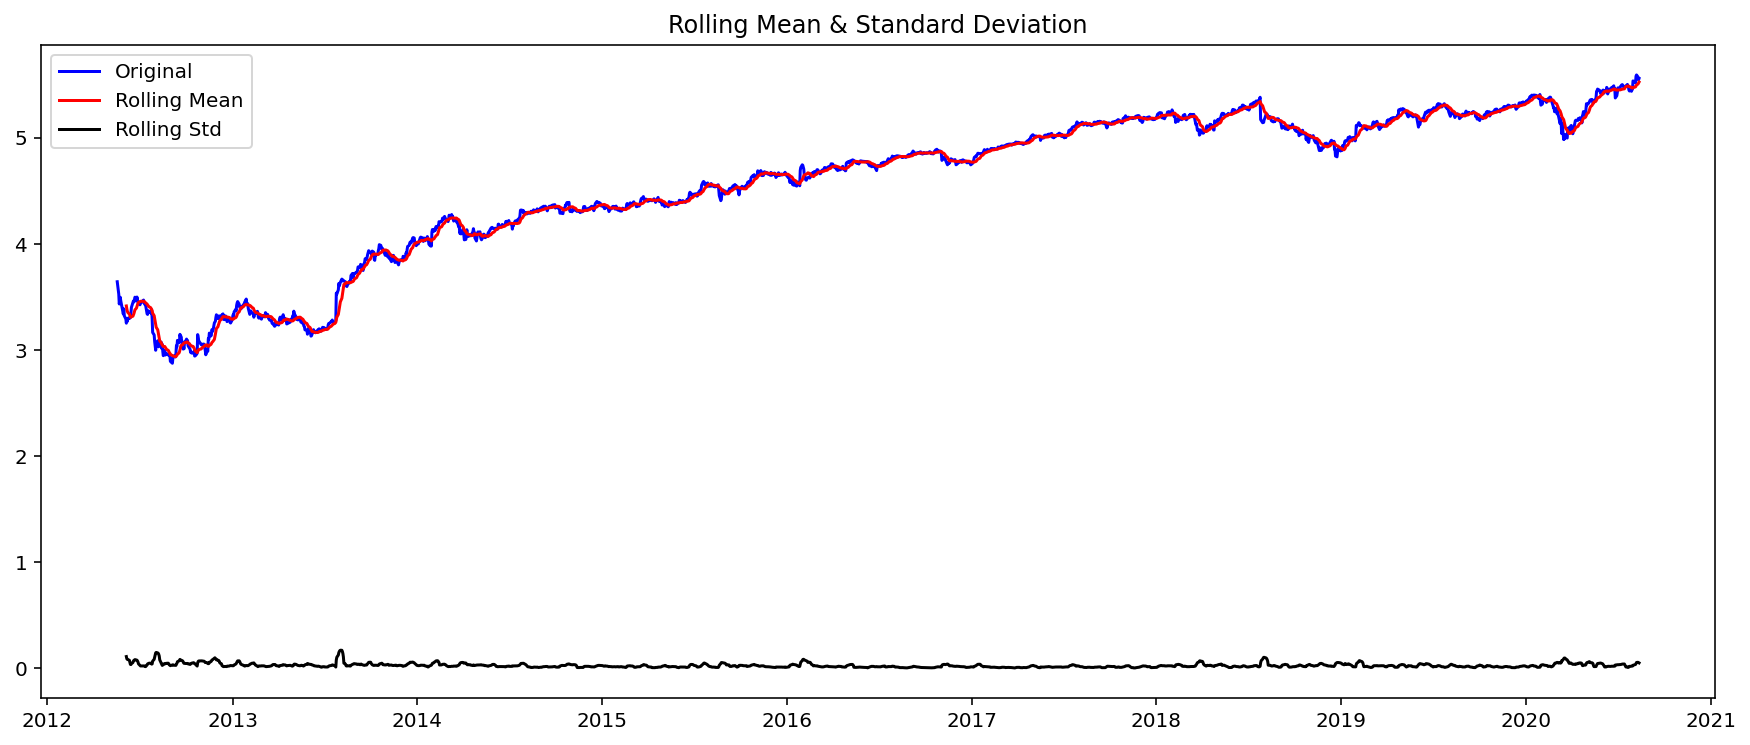

Results of Dickey-Fuller Test:
Test Statistic                   -1.182537
p-value                           0.681062
#Lags Used                       10.000000
Number of Observations Used    2061.000000
Critical Value (1%)              -3.433527
Critical Value (5%)              -2.862943
Critical Value (10%)             -2.567517
dtype: float64


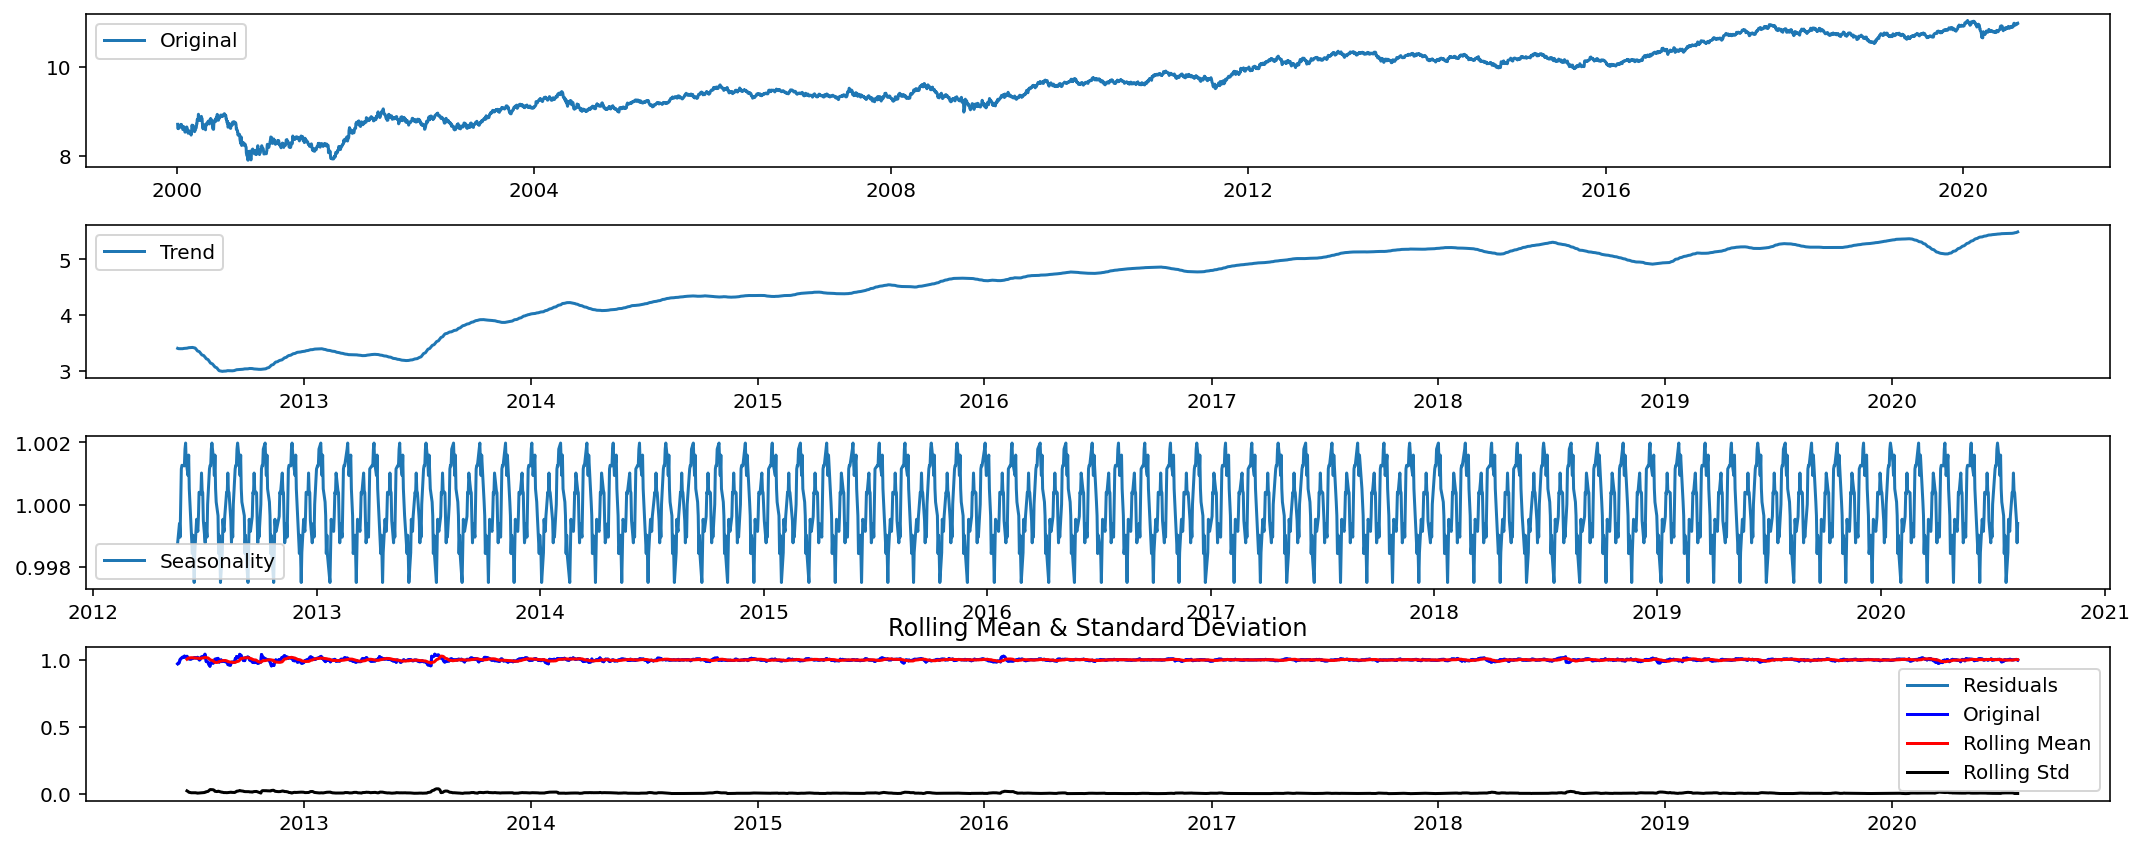

Results of Dickey-Fuller Test:
Test Statistic                -1.183524e+01
p-value                        7.818997e-22
#Lags Used                     2.600000e+01
Number of Observations Used    2.015000e+03
Critical Value (1%)           -3.433599e+00
Critical Value (5%)           -2.862975e+00
Critical Value (10%)          -2.567534e+00
dtype: float64
Date
2012-05-18    3.643621
2012-05-21    3.527242
Name: Close, dtype: float64
(1864,)
(208,)


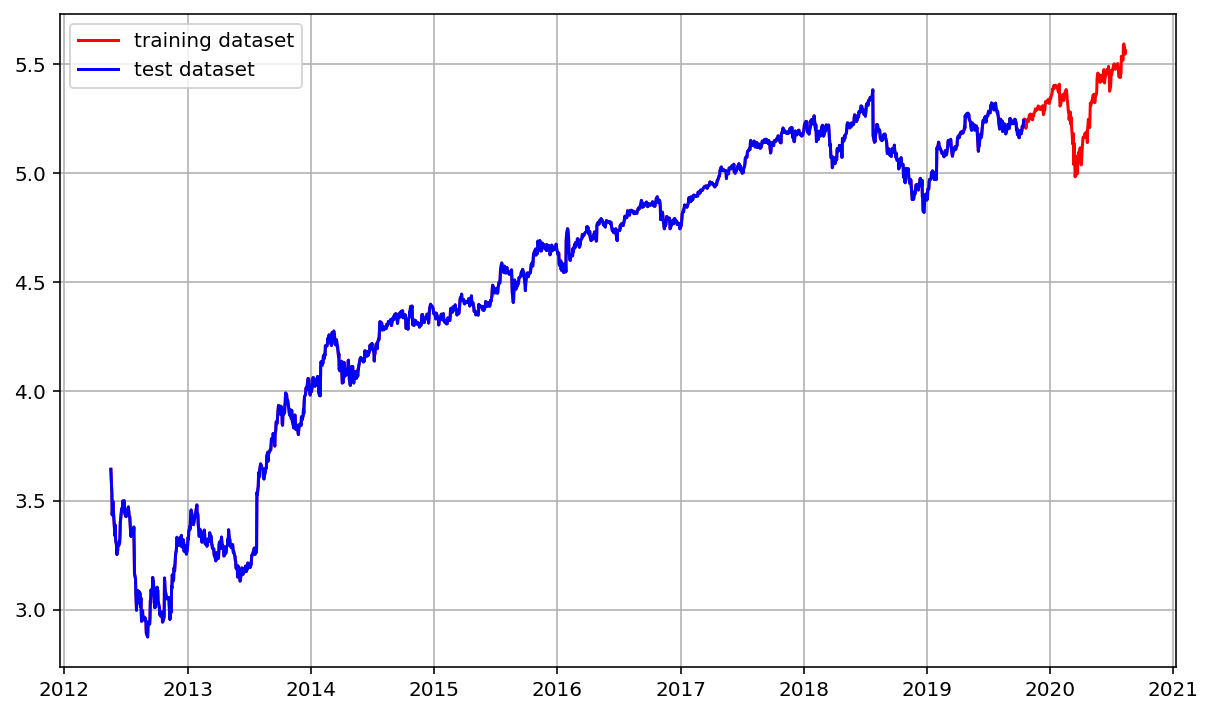

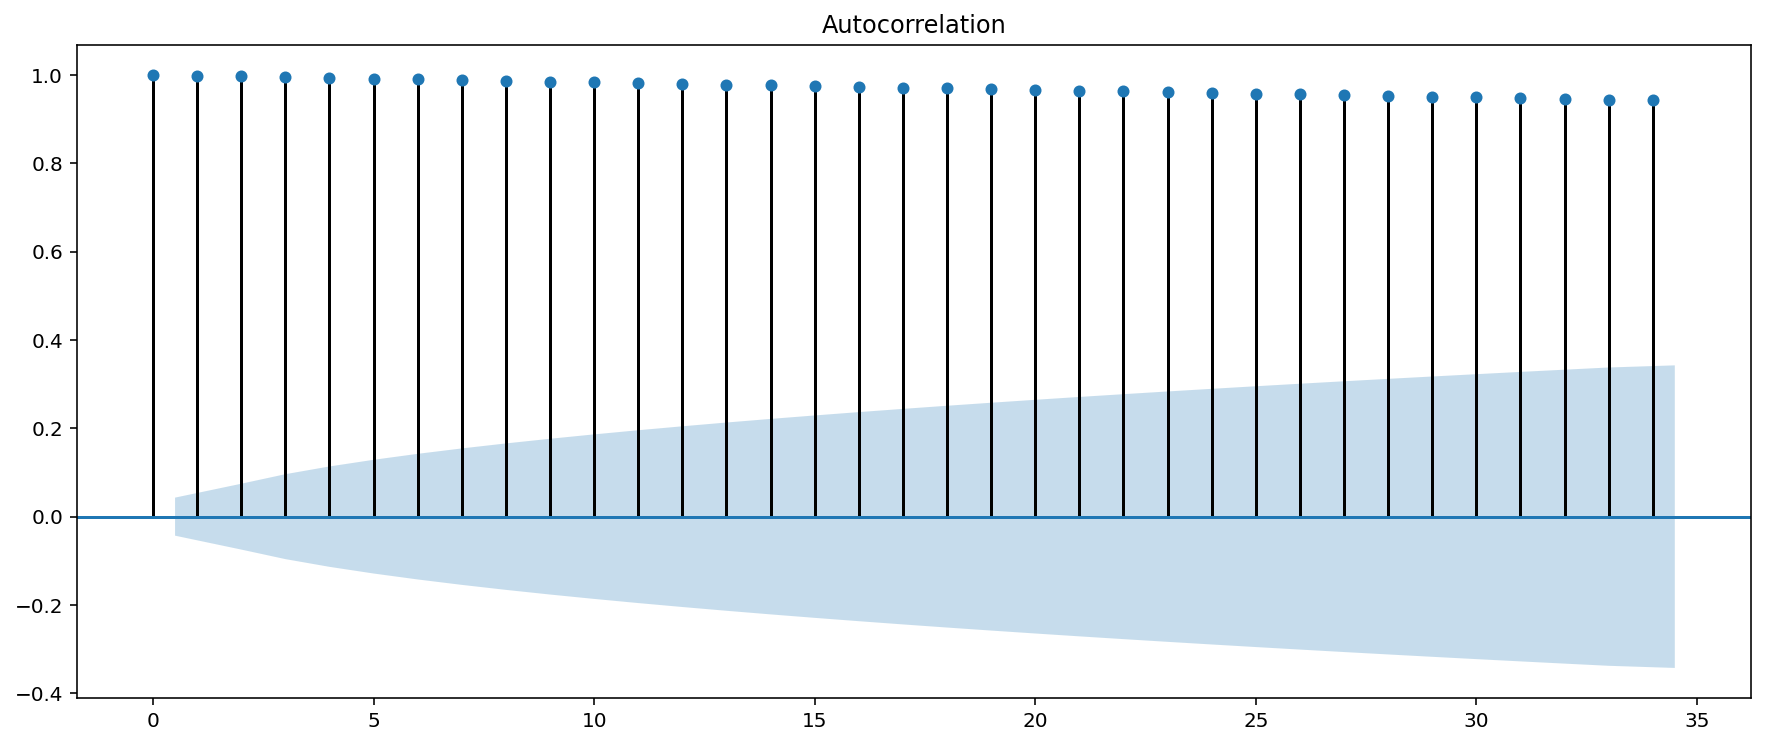

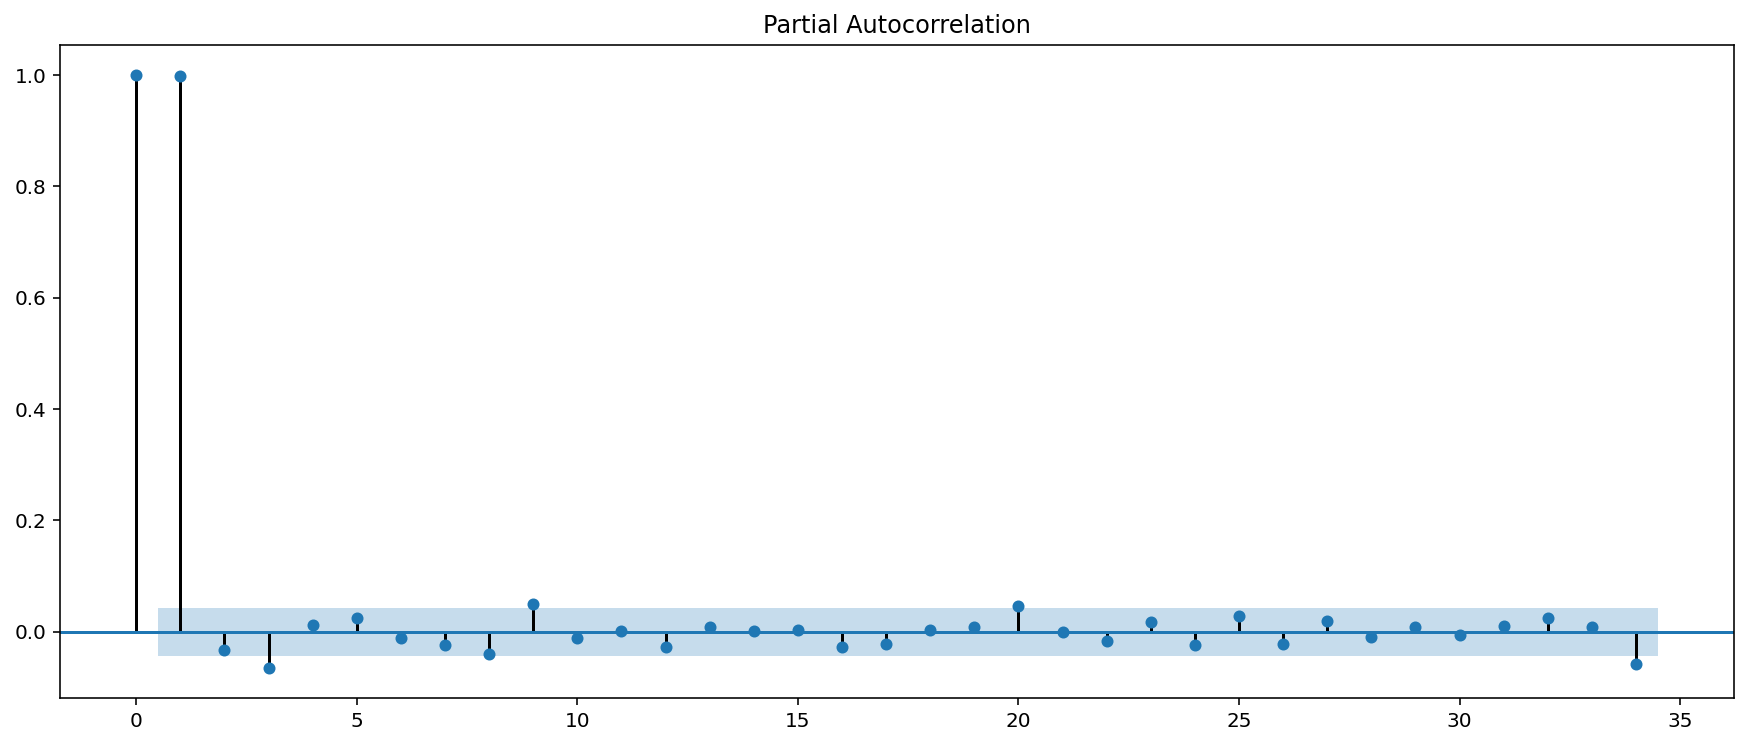

Results of Dickey-Fuller Test:
Test Statistic                -1.440184e+01
p-value                        8.483075e-27
#Lags Used                     1.000000e+01
Number of Observations Used    2.060000e+03
Critical Value (1%)           -3.433528e+00
Critical Value (5%)           -2.862944e+00
Critical Value (10%)          -2.567517e+00
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1863
Model:                 ARIMA(0, 1, 4)   Log Likelihood                4402.848
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Aug 2020   AIC                          -8793.697
Time:                        17:00:09   BIC                          -8760.517
Sample:                             1   HQIC                         -8781.470
                                                                              
              

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


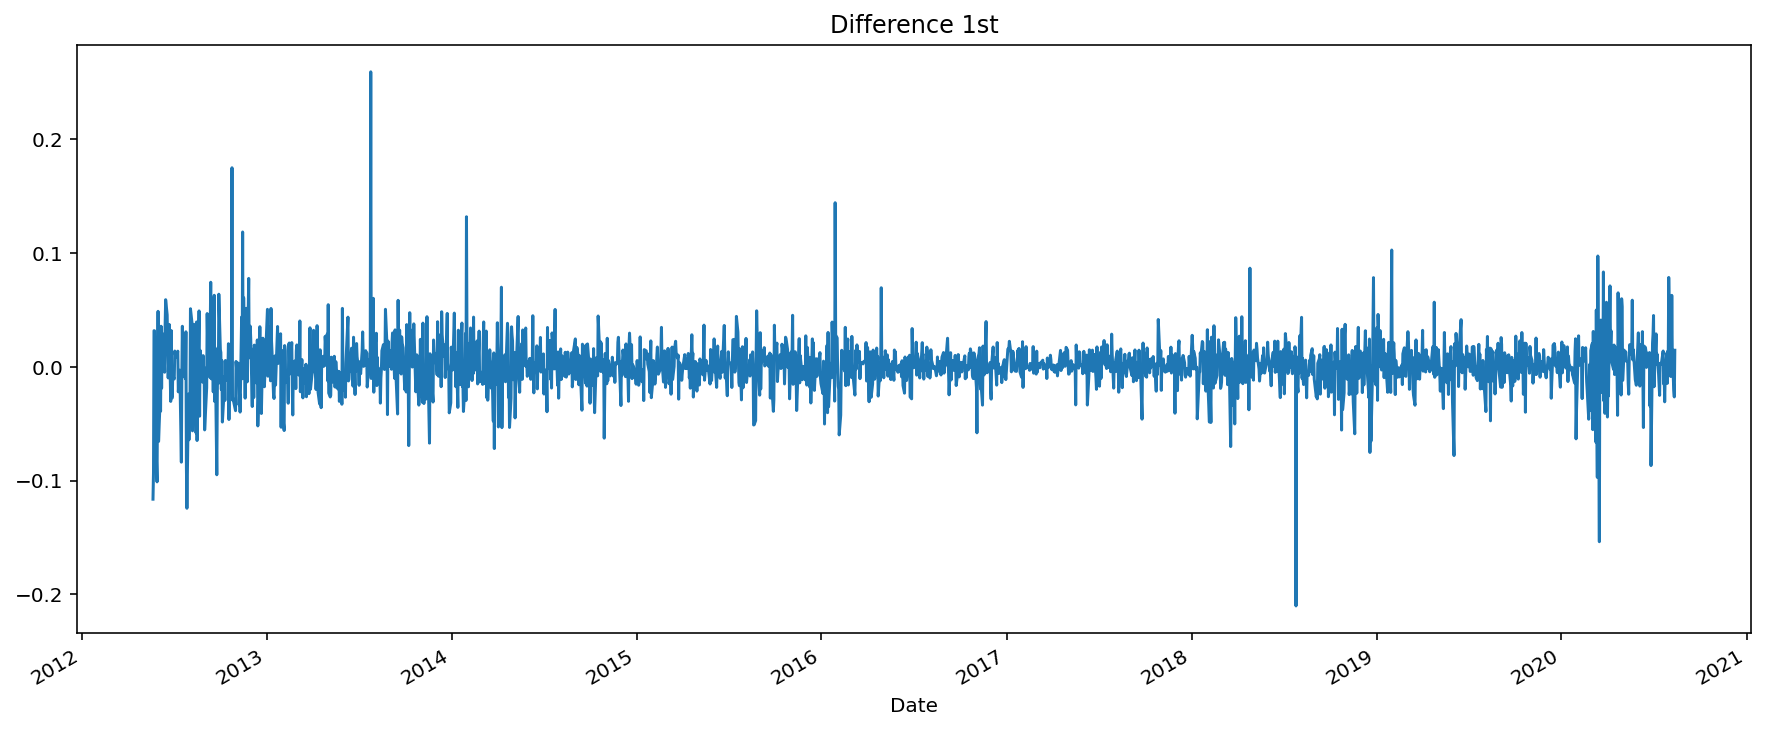

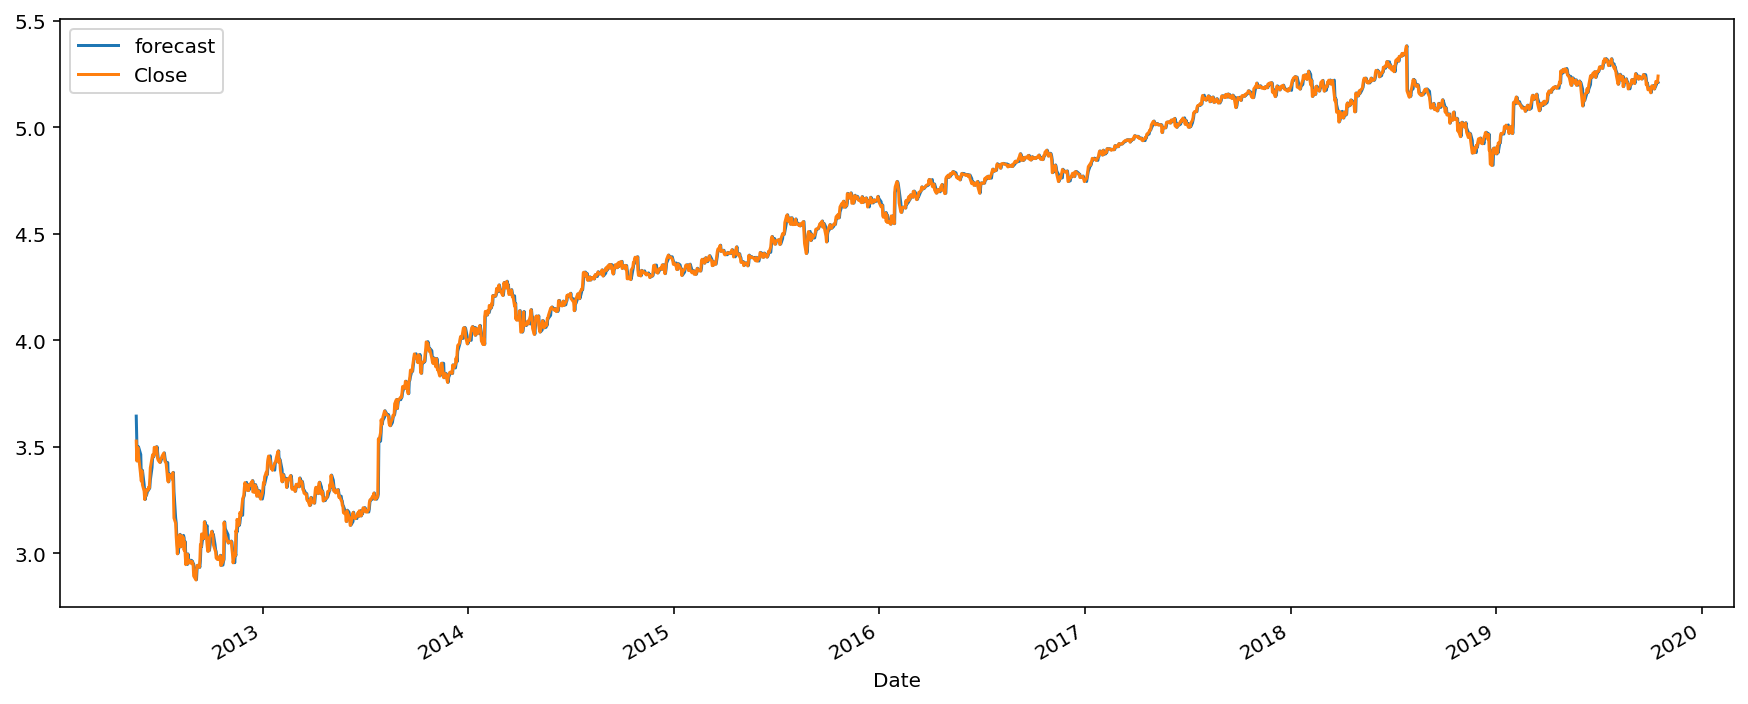

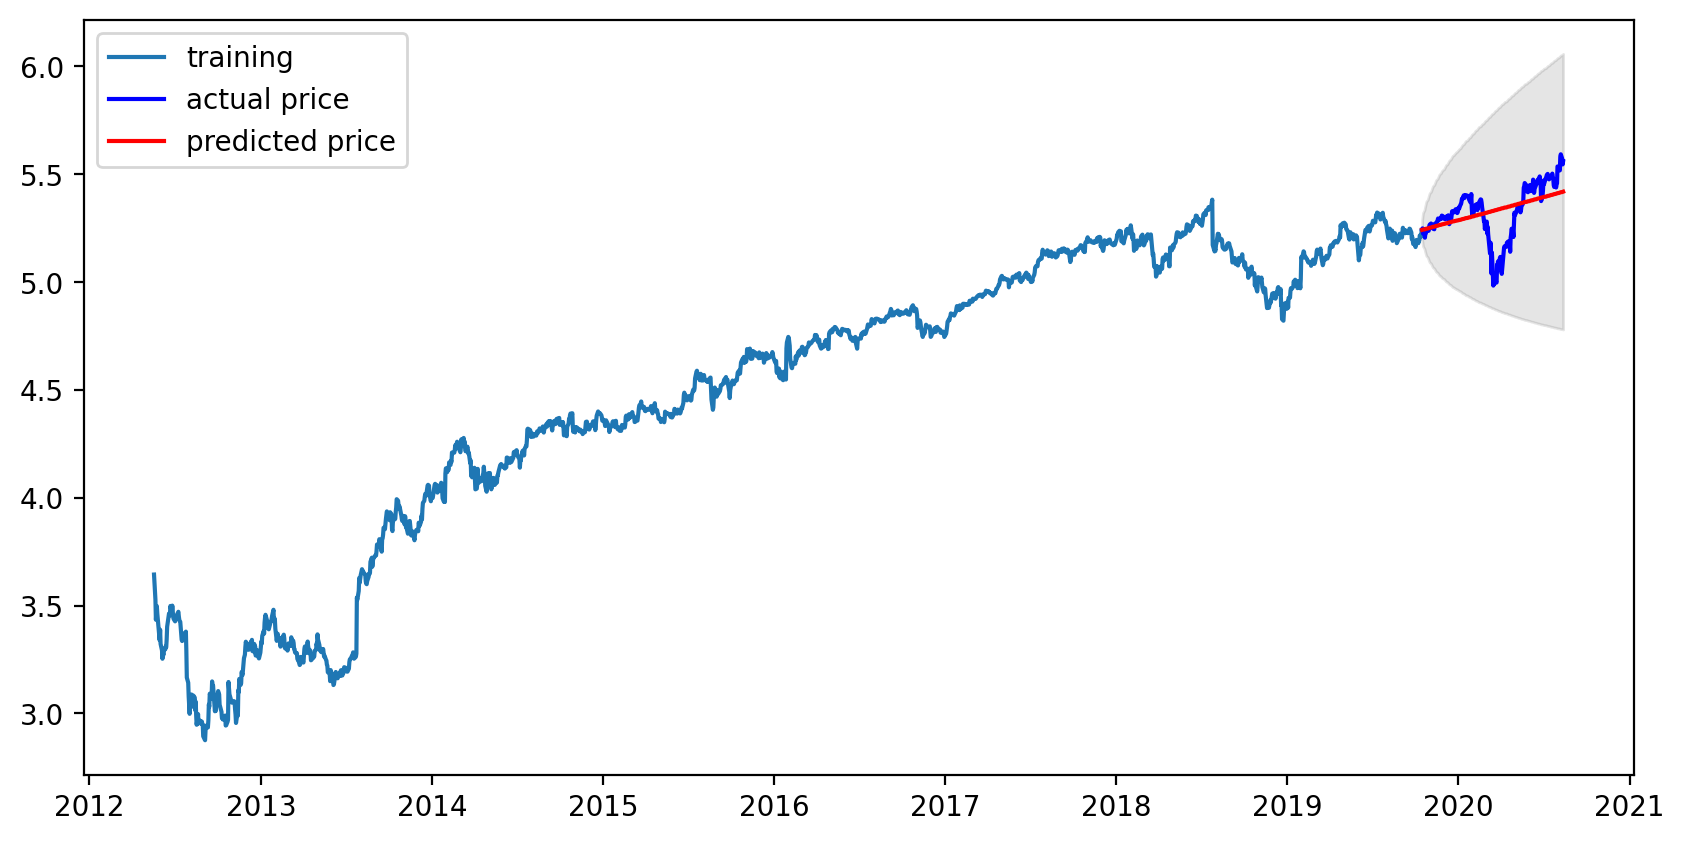

MSE:  487.11039486483514
MAE:  16.71725420392465
RMSE:  22.070577583399015
MAPE: 0.43%


In [232]:
#data import
file_path_fb = './data/facebook.csv'
#file_path_fb = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/E06-Stationary_Time_Series/data/asiana_airlines.csv' 

facebook = pd.read_csv(file_path_fb, index_col="Date", parse_dates=True)
facebook.head()

#series object exprot
fb_s = facebook['Close']
fb_s.head()

#전처리
fb_s = fb_s.interpolate(method="time")
fb_s[fb_s.isna()]
plt.plot(fb_s)

# 로그 함수 씌우기
fb_s_log = np.log(fb_s)
plt.plot(fb_s_log)

#
#로그 전.
plot_rolling_statistics(fb_s, window=12)
# 로그 후.
plot_rolling_statistics(fb_s_log, window=12)

augmented_dickey_fuller_test(fb_s_log)

# 시계열 분석

decomposition = seasonal_decompose(fb_s_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual= decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 안정성 확인
# Residual 로 확인
plot_rolling_statistics(residual) # 그래프
residual.dropna(inplace=True) # nan 제거
augmented_dickey_fuller_test(residual) # 귀무가설 확인

# train, test data spilt
train_fb_data, test_fb_data = fb_s_log[:int(len(fb_s_log)*0.9)], fb_s_log[int(len(fb_s_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(fb_s_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(train_fb_data, c='b', label='test dataset')
plt.legend()

# data set check
print(fb_s_log[:2])
print(train_fb_data.shape)
print(test_fb_data.shape)


plot_acf(fb_s_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(fb_s_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 1차 차분 구하기
diff_1 = fb_s_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


#훈련


# Build and Train  Model
model = ARIMA(train_fb_data, order=(0, 1, 4))
fit_model = model.fit(disp=-1)
print(fit_model.summary())

fit_model.plot_predict()

# 데이터 구간
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fit_model.forecast(len(test_fb_data), alpha=0.05)  # 95% conf
#   step , 
# alpha 


# Make as pandas series
fc_series = pd.Series(fc, index=test_fb_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_fb_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_fb_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_fb_data, label='training')
plt.plot(test_fb_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_fb_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_fb_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_fb_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_fb_data))/np.abs(np.exp(test_a_data)))
print('MAPE: {:.2f}%'.format(mape*100))